# Project: Car Price prediction (part 3 - Modelling)

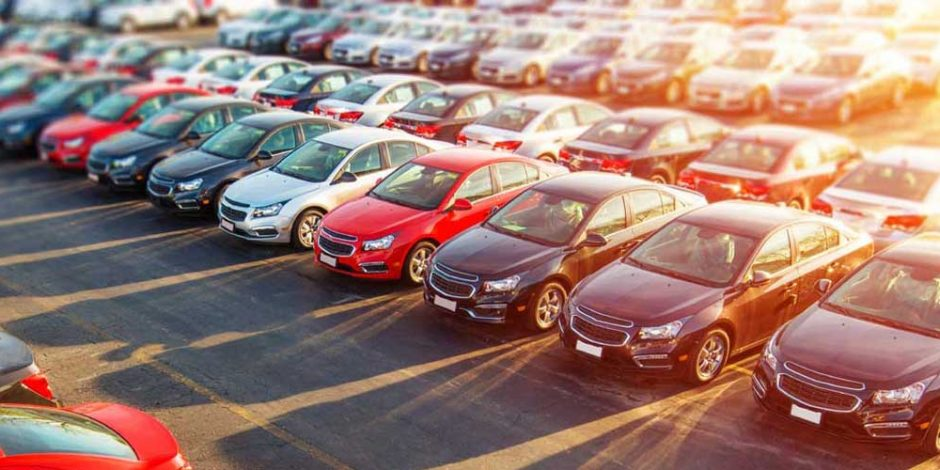

Цель данного ноутбука моделирование. 

<a id='chapters'>План действий:</a>
1. [Загружаем тренировочные данные (train) и смотрим их](#p_1)
1. [Загружаем тестовые данные (test) и смотрим их](#p_2)
1. [Объединяем test и train и изучим их](#p_3)
1. [Строим "наивную" модель](#p_4)
1. [Добавляем новые признаки](#p_5)
1. [Финальное моделирование](#p_6)
1. [Submission](#p_7)

2. [Выводы](#p_8)
    
Итак, всё есть - приступим.

<p style="color:green">#############################################################################################</p>  

## Импортируем библиотеки

In [5]:
from xgboost import XGBRegressor
from category_encoders import MEstimateEncoder
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import sidetable
import re
import json
import sys
import numpy as np
import pandas as pd
# import pandas_profiling
import time
import datetime

from tqdm.auto import tqdm, trange

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# from sklearn.metrics import mean_absolute_percentage_error #на одной машине не хватило прав установить

In [2]:
# pip install pandas_profiling

  Using cached pandas_profiling-3.1.0-py2.py3-none-any.whl (261 kB)
  Using cached phik-0.12.0-cp38-cp38-win_amd64.whl (659 kB)
  Using cached MarkupSafe-2.0.1-cp38-cp38-win_amd64.whl (14 kB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 0.17.0
    Uninstalling joblib-0.17.0:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Отказано в доступе: 'c:\\programdata\\anaconda3\\lib\\site-packages\\joblib-0.17.0.dist-info\\direct_url.json'
Consider using the `--user` option or check the permissions.



In [6]:
# изменю опции по умолчанию - чтобы всё было видно
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [7]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.2


## Собственные функции

In [8]:
# функция расчета МАРЕ
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [431]:
# функция загрузки исходных данных
def get_read():
    # загрузим исходные данные (два файла - тк парсил частями и запутался в файлах, потеряв ауди и часть бмв)
    train = pd.read_csv('./data/df_msk_org.csv')
    train = pd.concat([train, pd.read_csv('./data/df_msk_org_0.csv')], ignore_index=True)
    train = train.drop_duplicates(keep='first')

    # исключаем проданные автомобили из набора данных
    train = train[train.z_sold_check.isna() == True]

    # именим тип данных в train
    for col in ['mileage', 'car_price']:
        if type(col) != int or type(col) != float:
            train[col] = train[col].apply(
                lambda x: x.replace("\\xa0", "").replace(' ', ''))
        else:
            pass
        train[col] = train[col].astype(int)

    # добавляем признак тренировочной набора данных
    train['sample'] = 1
    print(datetime.datetime.now(), '- исходные данные загружены')

    return train

In [432]:
# функция пересчета текстового признака в числовой.
# перевод в число месяцев владения
def get_months_owning(row):
    # найдем все числовые значения в тексте
    try:
        srch = re.findall(r'\d+', row['Владение'])
    except:
        srch = []

    # переведем всё в месяцы
    if len(srch) > 1:
        h = int(srch[0])*12 + int(srch[1])
    elif len(srch) == 1:
        h = int(srch[0])
    else:
        h = np.NaN

    return h

In [433]:
# первичная загрузка и обработка тестового набора данных
def get_test_dataset():
    # загружаем данные
    test = pd.read_csv('./data/test.csv')

    # добовляем отсутствующие признаки (они есть в train-e)
    test['sample'] = 0
    test['car_price'] = 0

    # пока просто бездумно заполним пустые значения (это для построения первой модели)
    # тут можно переделать на наиболее часто встречающееся значение по модели
    # (а если такое будет пустым, то прочто часто встречающееся значение)
    test['Владение'].fillna(test['Владение'].mode()[0], inplace=True)
    test['ПТС'].fillna(test['ПТС'].mode()[0], inplace=True)

    return test

In [434]:
# функция создания новых признаков

def get_new_features(df):
    # перезагрузим тестовую базу
    test = get_test_dataset()
    print(datetime.datetime.now(), '--- перезагрузили тестовую базу')

    # ------------------------------------------------------------------------------------------------------
    # теперь подготовим набор train

    # заменим в бренде наименование на наименование из тестовой базы
    df['brand'] = df['brand'].replace('MERCEDES-BENZ', 'MERCEDES')

    # заменим в типе топлива наименование на короткие
    df['fuelType'] = df['fuelType'].apply(lambda x: x.split(',')[0])

    # ------------------------------------------------------------------------------------------------------
    # создадим список "лишних" признаков на "z_" (я их делал "про запас")
    # они мне помогли на предыдущем шаге (при парсинге данных)
    cols_to_drop_add = []

    for item in df.columns.values.tolist():
        if item[:2] == 'z_':
            cols_to_drop_add.append(item)

    # теперь удалим "лишние" признаки на "z_"
    for col in cols_to_drop_add:
        try:
            df.drop([col], axis=1, inplace=True)
#             print(col,'- только что удален') # использовал на стадии отладки кода
        except:
            pass
#             print(col,'- уже нету в данных') # использовал на стадии отладки кода

    print(datetime.datetime.now(),
          '--- в train удалены лишние признаки (начинающиеся на "z_"')

    # ------------------------------------------------------------------------------------------------------
    # объединяем наборы test и train в один
    df = pd.concat([df, test], ignore_index=True)
    print(datetime.datetime.now(),
          '--- объединены наборы test и train в df')
#     print(df.isna().sum()) # использовал на стадии отладки кода

    # ------------------------------------------------------------------------------------------------------
    # работаем с признаками ()
#     list_cols = ['description', 'image',
#                        'Владение', 'Владельцы', 'Таможня']

    # создадим список признаков с пропусками
    dh = pd.DataFrame(df.isna().sum())
    list_cols = dh[dh[0] != 0].index.to_list()

    # создаю новые признаки обозначающие было значение пустым или с значением
    for item in list_cols:
        name = item + '_is_filled'
        try:
            df[name] = df[item].apply(
                lambda x: 1 if pd.isna(x) == False else 0)
        except:
            pass

    print(datetime.datetime.now(), '--- в df созданы признаки "_is_filled"')

    # ------------------------------------------------------------------------------------------------------
    # пока просто бездумно заполним пустые значения (это для построения первой модели)
    # заменим пропуски на mode по своему столбцу
    # здесь есть место для улучшения - сделать mode значения по моделям

    print(datetime.datetime.now(),
          '--- в df заменяем пропуски на mode по признаку')

    for item in list_cols:
        val = df[item].mode()[0]
        df[item].fillna(val, inplace=True)

    print(datetime.datetime.now(), '--- в df пропуски заполнены')
#     print(df.isna().sum()) # использовал на стадии отладки кода

    # ------теперь создаем новые признаки-----------------------------------------------------------------

    # признак длина описания
    df['description_length'] = df.description.apply(lambda x: len(str(x)))

    # ------признак mileage------------------------------------------------------------------------------
    #  сделаем группы по объему пробега
    mileage_borders = [0, 50000, 150000, 300000]
    df["mileage_group"] = df["mileage"].apply(lambda x: 3 if x >= mileage_borders[3]
                                              else(2 if x >= mileage_borders[2]
                                                   else(1 if x >= mileage_borders[1] else 0)))

    print(datetime.datetime.now(), '--- в df создан признак "mileage_group"')

    # ------признак modelDate----------------------------------------------------------------------------
    modelDate_borders = [2011, 2017, 2020]
    modelDate_borders_names = ['старые', 'побегавшие', 'хорошие', 'новые']

    df["modelDate_group"] = df["modelDate"].apply(lambda x: 3 if x >= modelDate_borders[2]
                                                  else(2 if x >= modelDate_borders[1]
                                                       else(1 if x >= modelDate_borders[0] else 0)))

    print(datetime.datetime.now(), '--- в df создан признак "modelDate_group"')

    # ------------------------------------------------------------------------------------------------------
    # выделим в новые признаки объем двигателя и его мощность
    df['engine_volume'] = df['super_gen'].apply(
        lambda x: round(int(json.loads(x)['displacement'])/1000, 1))

    field = 'engine_volume'
    list_of_models_with_zeros = df[df[field] == 0].model_info.tolist()
    list_of_models_with_zeros = list(set(list_of_models_with_zeros))

    # пройдем циклом и проставим наиболее часто встречающиеся значения вместо пропусков
    for model in list_of_models_with_zeros:
        fillna_value = df[df.model_info == model][field].mode()[0]
        if fillna_value == 0:
            # тут выяснилось, что не спарсилась мощность для электроавтомобилей
            # пока ставлю заглушку в 2 литра.
            #         fillna_value = 2 # хотел руками поставить 2, но и в среднем тоже чаще 2 литра
            #     лучше оставлю расчетное значение
            fillna_value = df[field].mode()[0]

        df.loc[(df.model_info == model) & (
            df[field] == 0), field] = fillna_value

    print(datetime.datetime.now(), '--- в df создан признак "engine_volume"')

    # ------------------------------------------------------------------------------------------------------
    df['engine_power'] = df['super_gen'].apply(
        lambda x: int(json.loads(x)['power']))
    print(datetime.datetime.now(), '--- в df создан признак "engine_power"')

    # теперь сформируем более общие признаки на их основе
    # сделаю группы: -2,2-3,3-4,4-5 и остальные
    engine_volume_borders = [2, 3, 4, 5]

    df["engine_volume_group"] = df["engine_volume"].apply(lambda x: 4 if x >= engine_volume_borders[3]
                                                          else(3 if x >= engine_volume_borders[2]
                                                               else(2 if x >= engine_volume_borders[1]
                                                                    else(1 if x >= engine_volume_borders[0] else 0))))

    print(datetime.datetime.now(), '--- в df создан признак "engine_volume"')

    # ------------------------------------------------------------------------------------------------------
    # и добавлю группу по мощности двигателя
    # сделаю группы: -150,150-250,250-350,350-450 и остальные
    engine_power_borders = [150, 250, 350, 450]

    df["engine_power_group"] = df["engine_power"].apply(lambda x: 4 if x >= engine_power_borders[3]
                                                        else(3 if x >= engine_power_borders[2]
                                                             else(2 if x >= engine_power_borders[1]
                                                                  else(1 if x >= engine_power_borders[0] else 0))))

    print(datetime.datetime.now(),
          '--- в df создан признак "engine_power_group"')

    # ------признак super_gen----------------------------------------------------------------------------
    # создадим список уникальных значений признака super_gen
    field = 'super_gen'
    list_super_gen = pd.Series(df[field].unique()).to_list()

    # и проставим код супер-гена в новый признак
    df['super_gen_group'] = df[field].apply(
        lambda x: list_super_gen.index(x))
    df.drop(field, axis=1, inplace=True)
    print(datetime.datetime.now(), '--- в df создан признак "super_gen_group"')

    # ------признак Владельцы----------------------------------------------------------------------------
    # соберем список моделей с пропущенным признаком
    field = 'Владельцы'
    list_of_models_with_nans = df[df[field].isna() == True].model_info.tolist()

    # пройдем циклом и проставим наиболее часто встречающиеся значения вместо пропусков
    for model in list_of_models_with_nans:
        fillna_value = df[df.model_info == model][field].value_counts(
            dropna=False).index.tolist()[0]
        df.loc[(df.model_info == model) & (
            df[field].isna() == True), field] = fillna_value

    df['Владельцы'] = df['Владельцы'].apply(
        lambda x: x if type(x) == float else int(x[0]))
    print(datetime.datetime.now(),
          '--- в df перевели признак "Владельцы" в цифру')

    # ------признак Владельцы----------------------------------------------------------------------------
    # соберем список моделей с пропущенным признаком
    field = 'Владение'
    list_of_models_with_nans = df[df[field].isna() == True].model_info.tolist()

    # пройдем циклом и проставим наиболее часто встречающиеся значения вместо пропусков
    for model in list_of_models_with_nans:
        fillna_value = df[df.model_info == model][field].value_counts(
            dropna=False).index.tolist()[0]
        df.loc[(df.model_info == model) & (
            df[field].isna() == True), field] = fillna_value

#     df['Владение'] = df['Владение'].apply(lambda x: x if type(x) == float else int(x[0]))
    print(datetime.datetime.now(),
          '--- в df заполнили признак "Владение"')

    # ------признак months_owning----------------------------------------------------------------------------
    # число месяцев владения
    df['months_owning'] = df.apply(lambda row: get_months_owning(row), axis=1)
    print(datetime.datetime.now(),
          '--- в df добавили признак "months_owning"')

    # ------------------------------------------------------------------------------------------------------
    # приведем значения к одинаковым
    df.Руль = df.Руль.replace('Левый', 'левый').replace('Правый', 'правый')
    df.ПТС = df.ПТС.replace('Оригинал', 'оригинал').replace(
        'Дубликат', 'дубликат')

    return df

In [435]:
# функция по замене текстовых значений на цифровые
# по сути сделал руками Label Encoding

# до этой функции была попытка использовать get_dummies -
# но количество признаков зашкалило - получилось более 600.
# поэтому руками написал замену текстовых значений на цифровые коды
# а вообще можно было использовать типовыую функцию
# но раз уж написал, то не стал менять.

def convert_to_numbers(df):

    # список признаков для обработки
    fields = ['bodyType', 'brand', 'color', 'fuelType', 'model_name',
              'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль',
              'brand_body_type', 'brand_production_year', 'brand_drive_type',
              'brand_fuel_type', 'fuel_drive_type']

    # пойдем циклом по каждому признаку
    for field in fields:
        # заполним список с уникальными значениями по данному полю
        list_uval = []
        for i in df[field].unique():
            list_uval.append(i)

        # теперь пройдем циклом и заменим текстовое значение на индекс в списке значений
        for item in list_uval:
            df[field] = df[field].replace(item, list_uval.index(item))

        # и попробуем изменить тип поля на числовой
        try:
            df[field] = df[field].apply(
                lambda x: x if type(x) == float else int(x[0]))
        except:
            pass

    print(datetime.datetime.now(), '--- перевели категории в цифру')
    return df

In [436]:
# функция для финальной зачистки датасета от лишних признаков
def clear_dataset(df):
    # список удаляемых признаков
    cols_to_drop = ['car_url', 'description', 'complectation_dict',
                    'equipment_dict', 'image', 'model_info', 'parsing_unixtime',
                    'priceCurrency', 'super_gen', 'card_id', 'offers_dict',
                    'Таможня', 'Состояние', 'vehicleConfiguration', 'name',
                    'enginePower', 'engineDisplacement', 'engine_volume',
                    'engine_power', 'modelDate', 'Владение']

    for col in cols_to_drop:
        try:
            df.drop([col], axis=1, inplace=True)
        except:
            pass

    print(datetime.datetime.now(), '--- зачистили от лишних признаков (много пропусков,\
    одно значение или промежеточный признак)')
    print(datetime.datetime.now(), 'Готово')

    return df

In [481]:
# здесь будут реализованы дополнительные новые признаки
# разделил для более легкого прогона моделей
def get_new_features_2(df):

    # параметр для округления, оставляем число знаков после запятой.
    round_num = 4

    # -------блок признаков из признака мощности-------------------------------------------------------------
    # отношение мощности к объему двигателя
    df['power_volume'] = round(
        df['engine_power'] / df['engine_volume']*100, round_num)

    # медианная мощность для каждой модели
    df['median_power_model_name'] = round(df.groupby(
        'model_name')['engine_power'].transform('median'), round_num)

    # медианная мощность для каждого типа кузова
    df['median_power_body_type'] = round(df.groupby(
        'bodyType')['engine_power'].transform('median'), round_num)

    # медианная мощность для каждого типа топлива
    df['median_power_fuel_type'] = round(df.groupby(
        'fuelType')['engine_power'].transform('median'), round_num)

    # медианная мощность для каждого типа привода
    df['median_power_drive'] = round(df.groupby(
        'Привод')['engine_power'].transform('median'), round_num)

    # медианная мощность для каждого бренда
    df['median_power_brand'] = round(df.groupby(
        'brand')['engine_power'].transform('median'), round_num)

    print(datetime.datetime.now(),
          '--- создали доппризнаки на основе признака "power_volume"')

    # -------блок признаков из признака бренда--------------------------------------------------------------
    # объединенный признак бренда и типа кузова
    df['brand_body_type'] = df['brand'] + '_' + df['bodyType']

    # объединенный признак бренда и года производства
    df['brand_production_year'] = df['brand'] + \
        '_' + [str(x) for x in df['productionDate']]

    # объединенный признак бренда и типа привода
    df['brand_drive_type'] = df['brand'] + '_' + df['Привод']

    # объединенный признак бренда и типа топлива
    df['brand_fuel_type'] = df['brand'] + '_' + df['fuelType']

    print(datetime.datetime.now(),
          '--- создали доппризнаки на основе признака "brand"')

    # ------------------------------------------------------------------------------------------------------
    # объединенный признак типа топлива и типа привода
    df['fuel_drive_type'] = df['fuelType'] + '_' + df['Привод']
    print(datetime.datetime.now(),
          '--- создали доппризнак на основе признака "fuelType" и "Привод"')

    # ------------------------------------------------------------------------------------------------------
    # посчитаем возраст конкретного автомобиля
    df['car_age'] = 2022 - df['productionDate']

    # поскольку у нас уже заканчивается 2021 - то для этого года выпуска уже можно ставить 1
    # но лучше мы заменим 2021 на 2022 в предыдущем шаге - меньше обработок будет
#     df['car_age'] = df['car_age'].apply(
#         lambda x: 1 if x = 2021 else x)

    # посчитаем возраст модели (модель производят на протяжении нескольких лет)
    df['model_age'] = 2021 - df['modelDate']
    print(datetime.datetime.now(
    ), '--- создали доппризнаки на основе признака "modelDate" и "productionDate"')

    # ------------------------------------------------------------------------------------------------------
    # медианный пробег для каждой модели
    df['median_mileage_model'] = round(df.groupby(
        'model_name')['mileage'].transform('median'), round_num)

    # медианный пробег для каждого типа кузова
    df['median_mileage_body_type'] = round(df.groupby(
        'bodyType')['mileage'].transform('median'), round_num)

    # среднегодовой пробег автомобиля
    df['miles_in_year'] = round(df['mileage']/df['car_age'], round_num)

    print(datetime.datetime.now(),
          '--- создали доппризнаки на основе признака "mileage"')

    # ------------------------------------------------------------------------------------------------------
    # бинарный признак: машина старше 3 лет (1-моложе, 0-старше)
    df['car_older_3_years'] = df['productionDate'].apply(
        lambda x: 1 if x < 2021 - 3 else 0)

    # бинарный признак: машина старше 5 лет (1-моложе, 0-старше)
    df['car_older_5_years'] = df['productionDate'].apply(
        lambda x: 1 if x < 2021 - 5 else 0)

    # бинарный признак: машина в топ-2 популярных кузовов (1-Да, 0-Нет)
    list_top_bodyTypes = df['bodyType'].value_counts(dropna=False)[
        :2].index.to_list()
    df['top_bodyType'] = df['bodyType'].apply(
        lambda x: 1 if x in list_top_bodyTypes else 0)

    # бинарный признак: машина в топ-9 наименее популярных кузовов (1-Да, 0-Нет)
    list_bottom_bodyTypes = df_comp['bodyType'].value_counts(
        dropna=False)[-9:].index.to_list()
    df['rare_bodyType'] = df.bodyType.apply(
        lambda x: 1 if x in list_bottom_bodyTypes else 0)

    # бинарный признак: машина в топ-5 популярных цветах (1-Да, 0-Нет)
    list_top_colors = df_comp['color'].value_counts(dropna=False)[
        :5].index.to_list()
    df['top_colors'] = df.color.apply(
        lambda x: 1 if x in list_top_colors else 0)

    # бинарный признак: машина в топ-6 наименее популярных кузовов (1-Да, 0-Нет)
    list_bottom_colors = df_comp['color'].value_counts(
        dropna=False)[-6:].index.to_list()
    df['rare_colors'] = df.color.apply(
        lambda x: 1 if x in list_bottom_colors else 0)

    # бинарный признак: машина в топ-2 популярных по числу дверей (1-Да, 0-Нет)
    df['top_door_num'] = df.numberOfDoors.apply(
        lambda x: 1 if x in [4, 5] else 0)

    print(datetime.datetime.now(), '--- создали бинарные доппризнаки')
    # ------------------------------------------------------------------------------------------------------

    return df

In [438]:
def check_features():
    k=0
    list_to_work=[]

    for item in train.columns:
        if train[item].dtypes!=test[item].dtypes:
    #         print(item,'- разные форматы')
            list_to_work.append(item)
            k+=1

    if k==0:
        print('форматы признаков совпадают)))')
    else:
        print('есть над чем поработать!!!!')
        print('разные фор"маты:')
        print(list_to_work)
        for item in list_to_work:
            print(item,'\t',train[item].dtypes,'|\t',test[item].dtypes)

<p style="color:green">#############################################################################################</p><br>
<font size="5">  
<a id='p_1' style="color:blue">1. Загружаем тренировочные данные и смотрим их</a></font> 

[назад к оглавлению](#chapters) | [предыдущая часть](#chapters) | [следующая часть](#p_2)

In [17]:
# загружаем тренировочные данные
train = get_read()

2021-12-07 09:24:10.825699 - исходные данные загружены


In [18]:
# display(pd.DataFrame(train.brand.value_counts(dropna=False))) # использовал если строка ниже несрабатывала
train.groupby(['brand'])['brand'].agg({'count'}).stb.subtotal()

,count
brand,
AUDI,1829
BMW,3378
HONDA,751
INFINITI,585
LEXUS,852
MERCEDES-BENZ,4717
MITSUBISHI,1822
NISSAN,2799
SKODA,1915


In [19]:
# удалю лишние признаки в train
cols_to_drop = ['car_url', 'description', 'complectation_dict','equipment_dict', 'image', 'model_info', 'parsing_unixtime',
                'priceCurrency', 'super_gen', 'card_id', 'offers_dict']#,'Состояние', 'Таможня']

cols_to_drop_add=[]

# удаляю дополнительно спарсенные признаки (я дал им префикс "z_")
# создаю второй список для них
for item in train.columns.values.tolist():
    if item[:2]=='z_':
        cols_to_drop_add.append(item)

# по суммарному списку производим зачистку
for col in cols_to_drop + cols_to_drop_add:
    try:
        train.drop([col], axis=1,inplace=True)
#         print(col,'- только что удален') # использовал для отладки
    except:
        pass
#         print(col,'- уже нету в данных') # использовал для отладки

print('Лишние признаки удалены')

Лишние признаки удалены


In [17]:
# pip install pandas_profiling

In [17]:
# !pip install -U pandas-profiling

In [18]:
import pandas_profiling
train_profile = pandas_profiling.ProfileReport(train)
train_profile

TypeError: concat() got an unexpected keyword argument 'join_axes'

In [19]:
# train_profile.to_file("train_profile_clean_dataset.html")

In [20]:
# проверяем признаки на пропуски
print(train.isna().sum())

# пока просто бездумно заполним пустые значения (это для построения первой модели)
# заменим пропуски на mode по своему столбцу
dh = pd.DataFrame(train.isna().sum())
list_cols = dh[dh[0]!=0].index.to_list()

print('\n---заменяем пропуски на mode по признаку')
for item in list_cols:
    val = train[item].mode()[0]
    train[item].fillna(val, inplace=True)

print('\n---пропуски заполнены')
print(train.isna().sum())

bodyType                    0
brand                       0
color                       0
engineDisplacement          0
enginePower                 0
fuelType                    0
mileage                     0
modelDate                   0
model_name                  0
name                        0
numberOfDoors               0
productionDate              0
sell_id                     0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   2
Владение                17686
ПТС                         0
Привод                      0
Руль                        0
Состояние                   0
Таможня                     1
car_price                   0
sample                      0
dtype: int64

---заменяем пропуски на mode по признаку

---пропуски заполнены
bodyType                0
brand                   0
color                   0
engineDisplacement      0
enginePower             0
fuelType                0
mileage         

<p style="color:green">#############################################################################################</p><br>
<font size="5">  
<a id='p_2' style="color:blue">2. Загружаем тестовые данные и смотрим их</a></font> 

[назад к оглавлению](#chapters) | [предыдущая часть](#p_1) | [следующая часть](#p_3)

In [21]:
# загрузим тестовые данные 
test = pd.read_csv('./data/test.csv')
test['sample']=0

# test_profile = pandas_profiling.ProfileReport(test)
# test_profile.to_file("test_profile_org_dataset.html")
# test_profile


In [22]:
# зачистим по списку удаленных признаков в train
# (сами признаки удалял тк они имеют пропуски и/или неинформативные и/или с дублирующейся информацией)

for col in cols_to_drop:
    try:
        test.drop([col], axis=1,inplace=True)
#         print(col,'- только что удален') # использовал для отладки
    except:
        pass
#         print(col,'- уже нету в данных') # использовал для отладки

print('Лишние признаки удалены')

# посмотрим не пропуски
test.isna().sum()

Лишние признаки удалены


bodyType                    0
brand                       0
color                       0
engineDisplacement          0
enginePower                 0
fuelType                    0
mileage                     0
modelDate                   0
model_name                  0
name                        0
numberOfDoors               0
productionDate              0
sell_id                     0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
sample                      0
dtype: int64

In [23]:
# остались пропуски((
# пока просто бездумно заполним пустые значения (это для построения первой модели)
test['Владение'].fillna(test['Владение'].mode()[0], inplace=True)
test['ПТС'].fillna(test['ПТС'].mode()[0], inplace=True)

# проверим теперь пропуски
test.isna().sum()

bodyType                0
brand                   0
color                   0
engineDisplacement      0
enginePower             0
fuelType                0
mileage                 0
modelDate               0
model_name              0
name                    0
numberOfDoors           0
productionDate          0
sell_id                 0
vehicleConfiguration    0
vehicleTransmission     0
vendor                  0
Владельцы               0
Владение                0
ПТС                     0
Привод                  0
Руль                    0
Состояние               0
Таможня                 0
sample                  0
dtype: int64

In [24]:
# test_profile = pandas_profiling.ProfileReport(test)
# test_profile.to_file("test_profile_clean_dataset.html")
# test_profile

In [25]:
# проверим test и train на совпадение по признакам
print('есть в train и нету в test:',set(train.columns) - set(test.columns))
print('есть в test и нету в train:',set(test.columns) - set(train.columns))

есть в train и нету в test: {'car_price'}
есть в test и нету в train: set()


In [26]:
# внесем необходимые изменения

# добавляем признак в test
test['car_price'] = 0
test['Владельцы'] = test['Владельцы'].apply(lambda x: int(x[0]))

# и проверяем на различия еще раз
print('есть в train и нету в test:',set(train.columns) - set(test.columns))
print('есть в test и нету в train:',set(test.columns) - set(train.columns))

есть в train и нету в test: set()
есть в test и нету в train: set()


признаки в наборах совпадают)) идем дальше.

<p style="color:green">#############################################################################################</p><br>
<font size="5">  
<a id='p_3' style="color:blue">3. Объединяем test и train и изучим их</a></font> 

[назад к оглавлению](#chapters) | [предыдущая часть](#p_2) | [следующая часть](#p_4)

Посмотрим теперь наши наборы данных на различия в типах данных

In [27]:
check_features()

есть над чем поработать!!!!
разные фор"маты:
['mileage', 'Владельцы', 'car_price']
mileage 	 int32 |	 int64
Владельцы 	 object |	 int64
car_price 	 int32 |	 int64


по факту у нас только один признак "Владельцы" отличается - займусь им

In [28]:
field='Владельцы'
list_of_models_with_nans = train[train[field].isna()==True].model_name.tolist()

# пройдем циклом и проставим наиболее часто встречающиеся у моделей значения вместо пропусков
for model in list_of_models_with_nans:
    fillna_value = train[train.model_info == model][field].value_counts(dropna=False).index.tolist()[0]
    train.loc[(train.model_info == model) & (train[field].isna()==True), field] = fillna_value
    
# теперь приведем признак "Владельцы" к числовому
train[field] = train[field].apply(lambda x: x if type(x) == float else int(x[0]))

In [29]:
# проверяем еще раз
check_features()

есть над чем поработать!!!!
разные фор"маты:
['mileage', 'car_price']
mileage 	 int32 |	 int64
car_price 	 int32 |	 int64


теперь всё хорошо - можно объединять данные

In [30]:
# объединяем наборы в один
df = pd.concat([train,test], ignore_index=True)
df.sample(4).T

,55179,7029,25319,16001
bodyType,хэтчбек 5 дв.,седан,седан,седан
brand,MITSUBISHI,VOLKSWAGEN,BMW,TOYOTA
color,красный,чёрный,чёрный,чёрный
engineDisplacement,1.6 LTR,1.8 LTR,2.0 LTR,2.5 LTR
enginePower,90 N12,150 N12,249 N12,181 N12
fuelType,бензин,бензин,бензин,бензин
mileage,240000,169832,40000,115000
modelDate,1995,2003,2019,2012
model_name,CARISMA,PASSAT,5ER,CAMRY
name,1.6 MT (90 л.с.),1.8 MT (150 л.с.),2.0 AT (249 л.с.),2.5 AT (181 л.с.)


In [31]:
# df_profile = pandas_profiling.ProfileReport(df)
# df_profile.to_file("df_clean_dataset.html")
# df_profile

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 936x288 with 0 Axes>

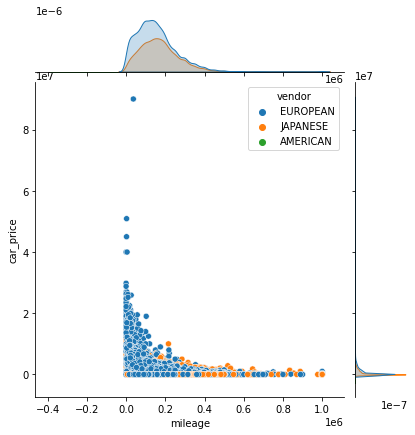

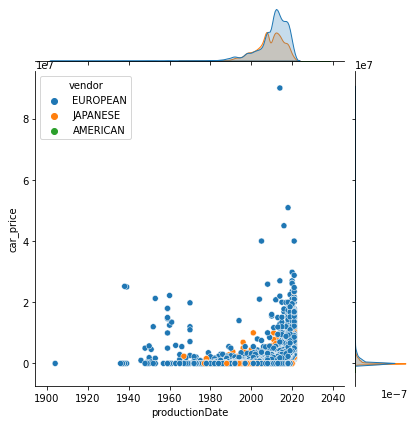

In [34]:
fig = plt.figure(figsize=(13, 4))
# plt.subplots(1,2)
f = sns.jointplot(x=df['mileage'], y=df['car_price'], hue=df['vendor'])
sns.jointplot(x=df['productionDate'], y=df['car_price'], hue=df['vendor'])
fig.tight_layout(pad=1.0)

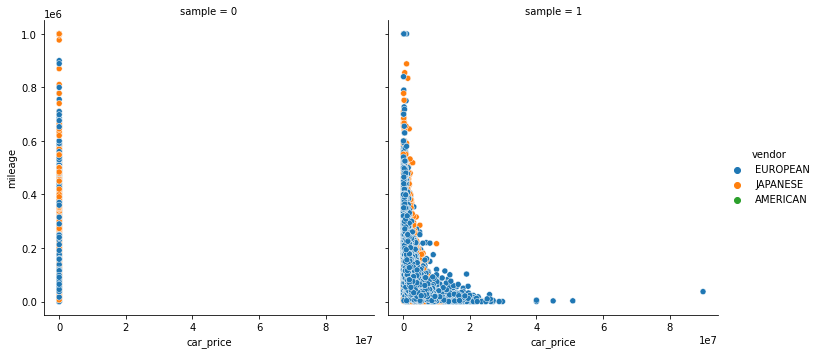

In [35]:
# Строим график:
sns.relplot(
    data=df,
    x='car_price',
    y='mileage',
    col='sample',
    hue='vendor')

# %matplotlib inline

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

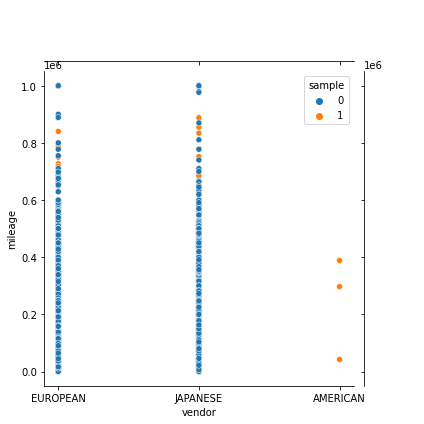

In [36]:
# Строим график:
sns.jointplot(
    data=df,
    x='vendor',
    y='mileage',
    hue='sample')

## Анализ Данных

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# начнем с описательной статистики
# поскольку нам надо смотреть отдельно на обучающий и тестовый наборы - разделим их.
train = df[df['sample']==1]
test = df[df['sample']==0]

In [39]:
# посмотрим на наш набор данных
df.sample(3)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,car_price,sample
21003,седан,BMW,чёрный,3.0 LTR,320 N12,дизель,19925,2020,7ER,3.0d AT (320 л.с.),4,2020,1106108546,SEDAN AUTOMATIC 740d,автоматическая,EUROPEAN,3,1 год и 1 месяц,оригинал,полный,левый,не требует ремонта,растаможен,7397000,1
31052,универсал 5 дв.,AUDI,синий,2.0 LTR,130 N12,бензин,164000,2000,A4,2.0 CVT (130 л.с.),5,2004,1094995172,WAGON_5_DOORS VARIATOR 2.0,вариатор,EUROPEAN,3,1 год и 10 месяцев,Дубликат,передний,Левый,Не требует ремонта,Растаможен,0,0
53624,седан,MITSUBISHI,серый,1.5 LTR,109 N12,бензин,167000,2007,LANCER,1.5 AT (109 л.с.),4,2010,1101129761,SEDAN AUTOMATIC 1.5,автоматическая,JAPANESE,1,1 год и 10 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60779 entries, 0 to 60778
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              60779 non-null  object
 1   brand                 60779 non-null  object
 2   color                 60779 non-null  object
 3   engineDisplacement    60779 non-null  object
 4   enginePower           60779 non-null  object
 5   fuelType              60779 non-null  object
 6   mileage               60779 non-null  int64 
 7   modelDate             60779 non-null  int64 
 8   model_name            60779 non-null  object
 9   name                  60779 non-null  object
 10  numberOfDoors         60779 non-null  int64 
 11  productionDate        60779 non-null  int64 
 12  sell_id               60779 non-null  int64 
 13  vehicleConfiguration  60779 non-null  object
 14  vehicleTransmission   60779 non-null  object
 15  vendor                60779 non-null

У нас 25 признаков, из них служебный 'sample' (разделение на тренировочный и тустовую выборку) и наш целевой car_price. Из остальных у нас 6 числовых и 17 категориальных признаков.

In [41]:
# посмотрим на число уникальных значений у категориальных признаков
df.select_dtypes(include='object').nunique().sort_values()

Таможня                    2
Состояние                  2
Привод                     3
vendor                     3
Руль                       4
ПТС                        4
vehicleTransmission        4
fuelType                   8
brand                     13
color                     16
bodyType                  24
engineDisplacement        56
Владение                 314
enginePower              335
model_name               599
vehicleConfiguration    1493
name                    3704
dtype: int64

In [42]:
# посмотрим на значения в признаках Руль и ПТС
display(df.Руль.value_counts())
display(df.ПТС.value_counts())

Левый     33287
левый     25171
Правый     1399
правый      922
Name: Руль, dtype: int64

Оригинал    30099
оригинал    22296
Дубликат     4587
дубликат     3797
Name: ПТС, dtype: int64

In [43]:
# приведем значения к одинаковым
df.Руль = df.Руль.replace('Левый', 'левый').replace('Правый', 'правый')
df.ПТС = df.ПТС.replace('Оригинал', 'оригинал').replace('Дубликат', 'дубликат')

Таким образом получается, что у нас 4 бинарных признака: Таможня, Состояние, Руль, ПТС.  
А вот вариантов значений у model_name, vehicleConfiguration и name зашкаливает и к этим полям нельзя применить One-hot Encoding - так как это значительно увеличит размерность наших данных.

In [44]:
display(train.drop(['sample','sell_id'], 1).describe().round(1))

,mileage,modelDate,numberOfDoors,productionDate,Владельцы,car_price
count,26093.0,26093.0,26093.0,26093.0,26093.0,26093.0
mean,155042.7,2010.8,4.5,2010.8,2.1,1880457.5
std,104102.7,7.6,0.7,7.6,0.9,2248999.0
min,1.0,1938.0,2.0,1938.0,1.0,30000.0
25%,78000.0,2007.0,4.0,2007.0,1.0,670000.0
50%,141000.0,2012.0,5.0,2012.0,2.0,1285000.0
75%,211000.0,2016.0,5.0,2016.0,3.0,2300000.0
max,1000000.0,2021.0,5.0,2021.0,3.0,90000000.0


Замечаем здесь не Гауссово распределение для mileage и car_price (слишком большая разница между средним и медианными значениями)

In [45]:
display(test.drop(['sample','sell_id'], 1).describe().round(1))

,mileage,modelDate,numberOfDoors,productionDate,Владельцы,car_price
count,34686.0,34686.0,34686.0,34686.0,34686.0,34686.0
mean,162009.8,2007.1,4.5,2009.3,2.2,0.0
std,100676.6,7.4,0.7,7.0,0.8,0.0
min,1.0,1904.0,0.0,1904.0,1.0,0.0
25%,91153.5,2004.0,4.0,2006.0,1.0,0.0
50%,149779.5,2008.0,5.0,2011.0,2.0,0.0
75%,215000.0,2012.0,5.0,2014.0,3.0,0.0
max,1000000.0,2020.0,5.0,2020.0,3.0,0.0


Глобально нету прямо очень большой разницы между наборами.

Отмечу следующее:  
    1. В обучающем наборе в среднем более новые по году выпуска автомобили  
    2. По длине пробега наборы практически не отличаются  
    3. Число владельцев совпадает    
    4. Медианное значение цены около 1,3млн рублей, а максимальное значение 90млн.  
    5. В тестовом наборе минимальная дата производства 1904 год, а в собранной мной обучающей выборке только 1938.

Числовые признаки

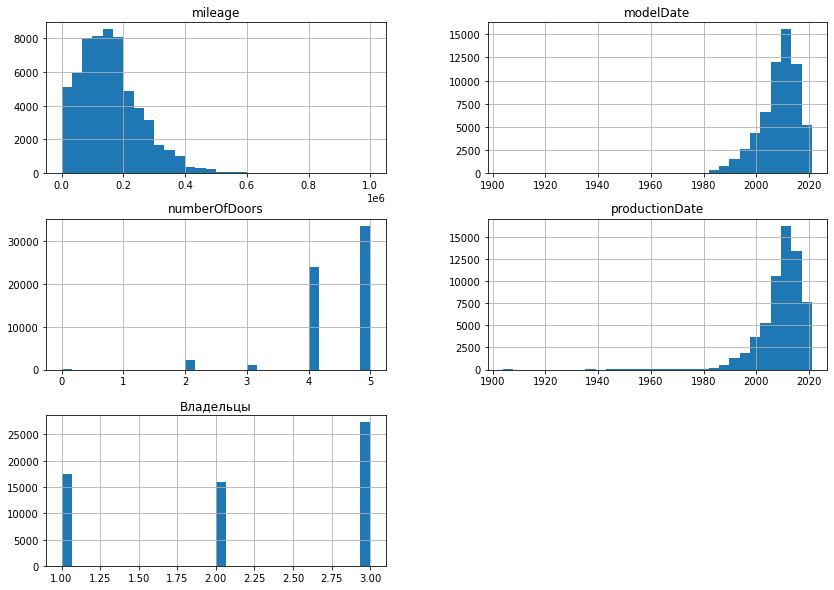

In [46]:
list_num = df.select_dtypes(include=['float64', 'int64']).drop(['car_price', 'sample','sell_id'], 1).columns.to_list()

df.loc[:, list_num].hist(sharex=False, sharey=False, bins=30, xlabelsize=10, ylabelsize=10, 
                                                    figsize=(14, 10))
plt.show()

* нигде нету Гайсова распределения  
* распределение mileage - lognormal  
* большинство автомобилей произведено после 2000  
* в основном автомобили имеют 4-5 дверей  
* по числу владельцев, в основном 1 или 3, реже 2.


Посмотрим на выбросы в данных - построим box-plot-ы.

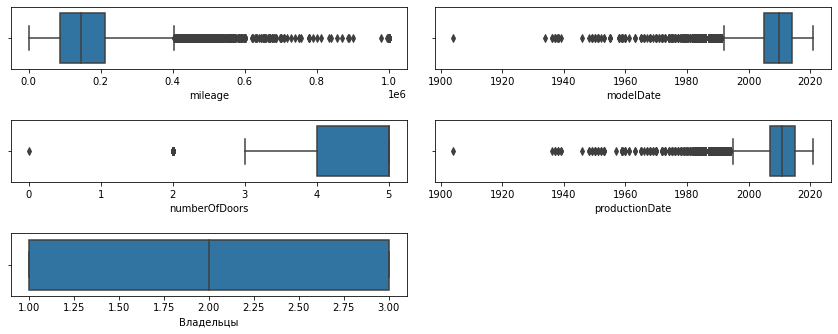

In [104]:
fig = plt.figure(figsize=(12, 5))

for index, col in enumerate(list_num):
    plt.subplot(3, 2, index+1)
    f = sns.boxplot(data=df, x=col)
fig.tight_layout(pad=2.0)

* графики показывают наличие большого числа выбросов у пробега и года модели/года производства (только я не согласен с этим - математика посчитала редкие предложения - выбросами, хотя такое действительно может быть).
* выбросов нет только по числу владельцев - оно и понятно, тк там всего три значения и они все рядом.
* productionDate аналогичен modelDate, только с сдвигом, это тоже все объяснимо. Обычно на старте производства нового модельного года идет постепенное наращивание объемов производства (происходит обкатка всех процессов производства)

In [48]:
# посмотрим на автомобиль 1904 года выпуска - может там опечатка в годе производства.
df[df['modelDate']==1904].T

,43037
bodyType,кабриолет
brand,MERCEDES
color,белый
engineDisplacement,5.3 LTR
enginePower,32 N12
fuelType,бензин
mileage,48000
modelDate,1904
model_name,SIMPLEX
name,5.3 MT (32 л.с.)


...выглядит все нормально... это похоже на настоящий автомобиль - опечаток нет.
https://ru.wikipedia.org/wiki/Mercedes_Simplex

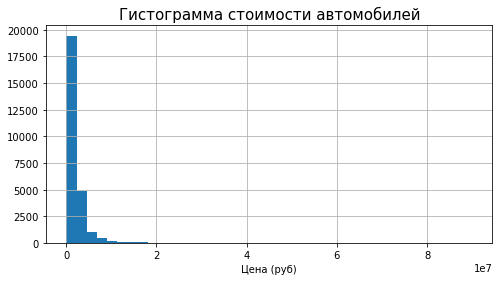

In [49]:
# Теперь посмотрим на наш целевой признак car_price
train['car_price'].hist(bins=40, xlabelsize=10, ylabelsize=10, figsize=(8, 4))
plt.title("Гистограмма стоимости автомобилей", fontsize=15)
plt.xlabel("Цена (руб)")
plt.show()

График похож на экспоненциальный.

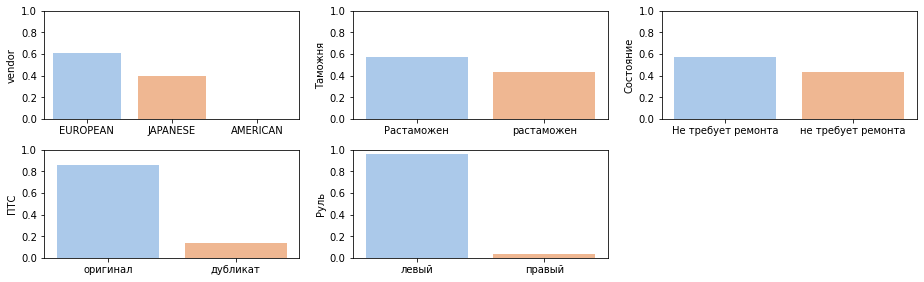

In [50]:
# Взглянем на бинарные признаки
list_bin = ['vendor', 'Таможня','Состояние' ,'ПТС', 'Руль']

fig = plt.figure(figsize=(13, 4))
for index, col in enumerate(list_bin):
    plt.subplot(2, 3, index+1)
    
    f = sns.barplot(x = df.loc[:, list_bin][col].value_counts(normalize=True).index, 
                y = df.loc[:, list_bin][col].value_counts(normalize=True), palette = "pastel")
    f.set(ylim=(0, 1))
    
fig.tight_layout(pad=1.0)

In [51]:
# Получается у меня при парсинге какием-то образом попал не тот вендор - проверим
df[df.vendor=='AMERICAN'].T

,1963,7001,8530
bodyType,минивэн,минивэн,внедорожник 5 дв.
brand,VOLKSWAGEN,VOLKSWAGEN,VOLKSWAGEN
color,красный,зелёный,красный
engineDisplacement,2.8 LTR,2.8 LTR,2.0 LTR
enginePower,201 N12,201 N12,238 N12
fuelType,бензин,бензин,бензин
mileage,297000,388500,42000
modelDate,2001,2002,2017
model_name,EUROVAN,EUROVAN,ATLAS
name,2.8 AT (201 л.с.),2.8 AT (201 л.с.),2.0 AT (238 л.с.)


А это производитель VW, почему то указали американский, и судя по названиям моделей это модели для американского рынка, и скорее всего они были произведены в Штатах. Но мы то знаем, что VW европейский - меняем на EUROPEAN.

In [52]:
df.vendor = df.vendor.replace('AMERICAN','EUROPEAN')

In [53]:
# В признаках 'Состояние' и 'Таможня' по факту только одно значение (только первая буква незаглавная).
# меняем с заглавной на нижний регистр.
df['Состояние'] = df['Состояние'].apply(lambda x: x.lower())
df['Таможня'] = df['Таможня'].apply(lambda x: x.lower())

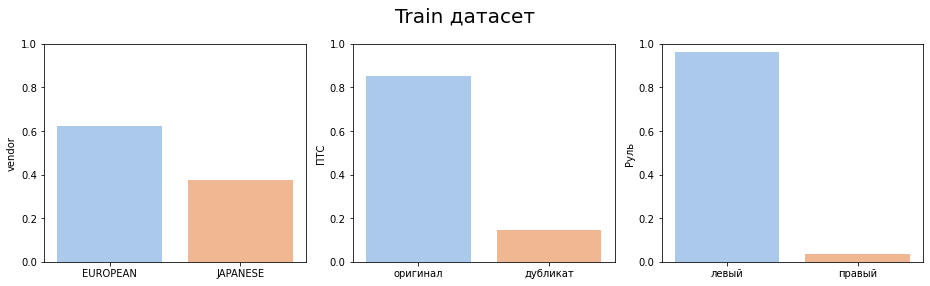

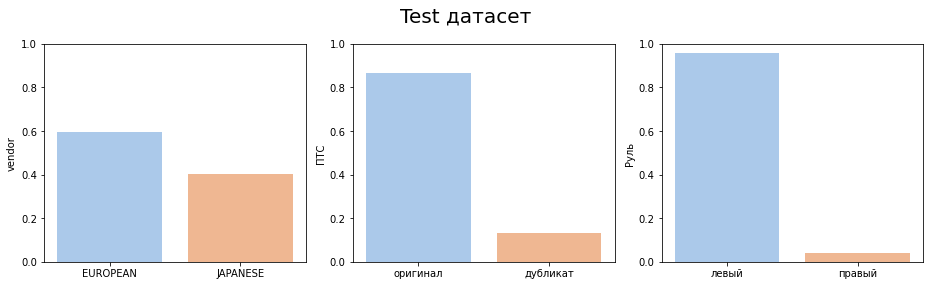

In [54]:
# Взглянем на бинарные признаки еще раз (исключим теперь 'Таможня' и 'Состояние')
list_bin = ['vendor', 'ПТС', 'Руль']

# построю аналогичные графики для train
fig = plt.figure(figsize=(13, 4))
for index, col in enumerate(list_bin):
    plt.subplot(1, 3, index+1)
    
    f = sns.barplot(x = df[df['sample']==1].loc[:, list_bin][col].value_counts(normalize=True).index, 
                    y = df[df['sample']==1].loc[:, list_bin][col].value_counts(normalize=True), 
                    palette = "pastel")
    f.set(ylim=(0, 1))

fig.suptitle('Train датасет', fontsize=20)
fig.tight_layout(pad=1.0)

# построю аналогичные графики для test
fig2 = plt.figure(figsize=(13, 4))
for index, col in enumerate(list_bin):
    plt.subplot(1, 3, index+1)
    
    f2 = sns.barplot(x = df[df['sample']==0].loc[:, list_bin][col].value_counts(normalize=True).index, 
                    y = df[df['sample']==0].loc[:, list_bin][col].value_counts(normalize=True), 
                    palette = "pastel")
    f2.set(ylim=(0, 1))
fig2.suptitle('Test датасет', fontsize=20)
fig2.tight_layout(pad=1.0)

Видно, что распределение в тестовой базе немного другое, в ней больше японских автомобилей. Остальные показатели одинаковые.

## Посмотрим на категориальные признаки

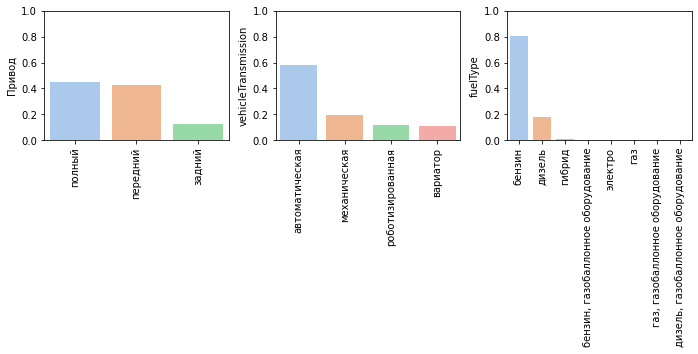

In [55]:
list_cat = ['Привод', 'vehicleTransmission', 'fuelType']

fig = plt.figure(figsize=(13, 5))
for index, col in enumerate(list_cat):
    plt.subplot(1, 4, index+1)
    plt.xticks(rotation='vertical')
    f = sns.barplot(x=df.loc[:, list_cat][col].value_counts(normalize=True).index,
                    y=df.loc[:, list_cat][col].value_counts(normalize=True),
                    palette="pastel")
    f.set(ylim=(0, 1))
fig.tight_layout(pad=1.0)

In [56]:
# как видно нам надо поработать с наименованием топлива
# оставлю только первый тип топлива, тк он основной.
df['fuelType'] = df['fuelType'].apply(lambda x: x.split(',')[0])

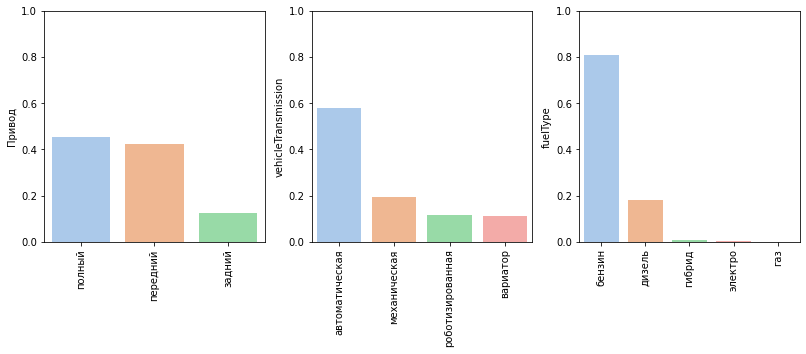

In [57]:
fig = plt.figure(figsize=(15, 5))
for index, col in enumerate(list_cat):
    plt.subplot(1, 4, index+1)
    plt.xticks(rotation='vertical')
    f = sns.barplot(x=df.loc[:, list_cat][col].value_counts(normalize=True).index,
                    y=df.loc[:, list_cat][col].value_counts(normalize=True),
                    palette="pastel")
    f.set(ylim=(0, 1))
fig.tight_layout(pad=1.0)

* Задний привод имеет наименьшую популярность  
* Атоматическая трансмиссия практически в 60% объявлений, что интересно, что на втором месте механика, а не робот или вариатор.  
* И бензиновые двигатели установлены в подавляющем числе автомобилей.

## Теперь посмотрим на категорийные признаки с большим числом значений.

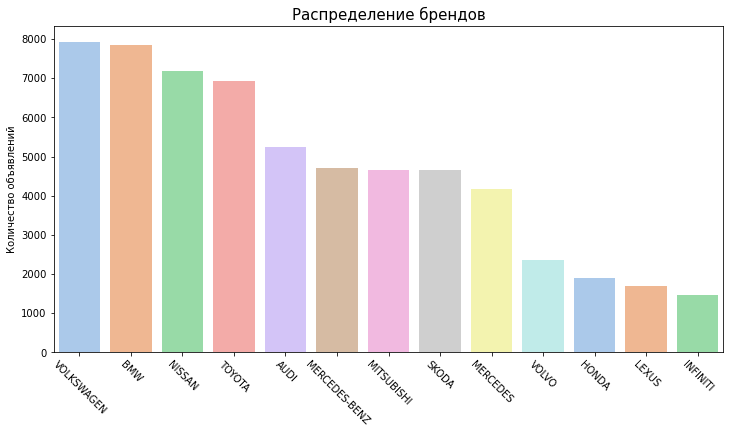

In [58]:
plt.figure(figsize=(12, 6))
sns.barplot(x=df.brand.value_counts().index, y=df.brand.value_counts().values, palette = "pastel")
plt.title("Распределение брендов", fontsize=15)
plt.xticks(rotation='-45')
plt.ylabel("Количество объявлений")
plt.show()

Тут тоже закралось расхождение в наименовании бренда. В тестовой выборке Mercedes, а у меня при парсинге Mercedes-Benz. Заменю на более короткое.

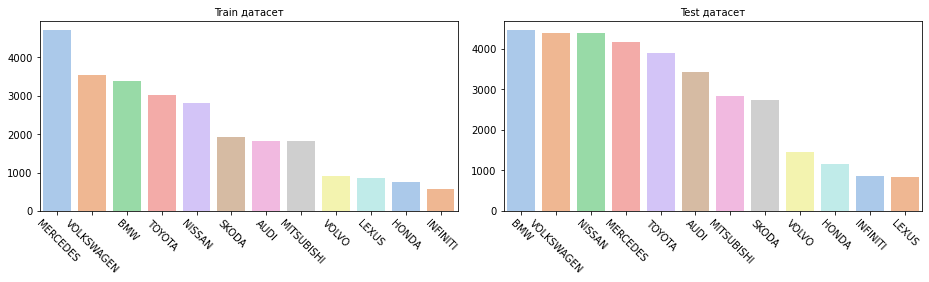

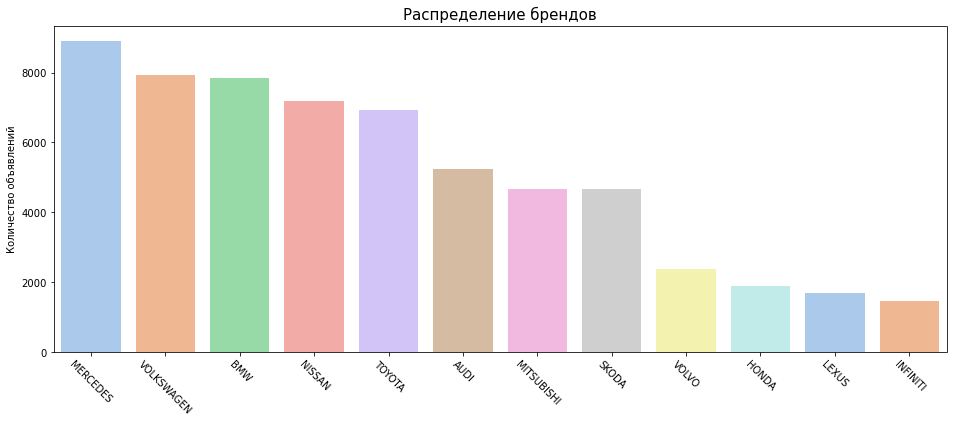

In [59]:
df.brand = df.brand.replace("MERCEDES-BENZ","MERCEDES")

# теперь построим графики для train и test и посмотрим на распределение брендов
fig = plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
    
f = sns.barplot(x=df[df['sample']==1].brand.value_counts().index, 
                    y=df[df['sample']==1].brand.value_counts().values, 
                    palette = "pastel")
plt.xticks(rotation='-45')
plt.title('Train датасет', fontsize=10)

plt.subplot(1, 2, 2)
f2 = sns.barplot(x = df[df['sample']==0].brand.value_counts().index, 
                    y = df[df['sample']==0].brand.value_counts().values, 
                    palette = "pastel")
plt.title('Test датасет', fontsize=10)
    
plt.xticks(rotation='-45')
fig.tight_layout(pad=1.0)

plt.figure(figsize=(16, 6))
sns.barplot(x=df.brand.value_counts().index, y=df.brand.value_counts().values, palette = "pastel")
plt.title("Распределение брендов", fontsize=15)
plt.xticks(rotation='-45')
plt.ylabel("Количество объявлений")
plt.show()

Mercedes, VW и BMW самые распространенные марки в моем наборе данных.  
Меньше всего автомобилей Infinity.

Посмотрим на распределение моделей.

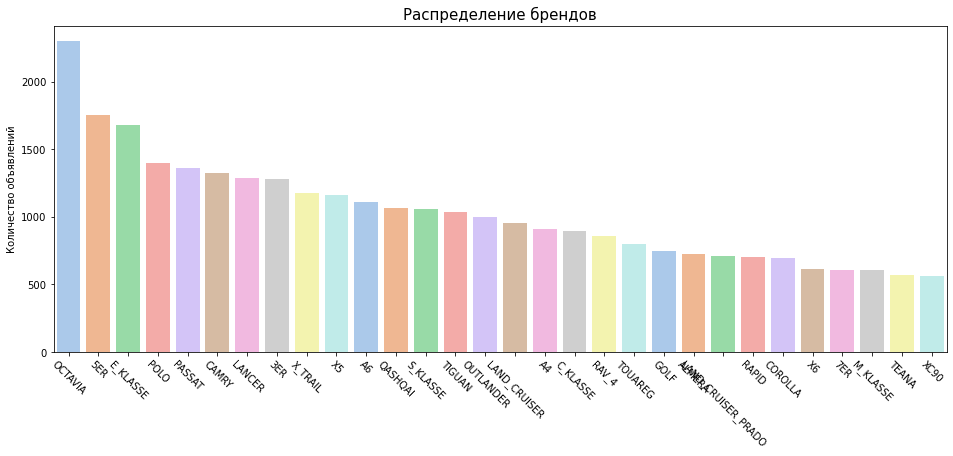

In [60]:
plt.figure(figsize=(16, 6))
sns.barplot(x=df.model_name.value_counts()[:30].index, y=df.model_name.value_counts()[:30].values, palette = "pastel")
plt.title("Распределение брендов", fontsize=15)
plt.xticks(rotation='-45')
plt.ylabel("Количество объявлений")
plt.show()

In [61]:
print(f'Пятерка наиболее встречающихся моделей в наборе {df.model_name.value_counts()[:5].index}')

Пятерка наиболее встречающихся моделей в наборе Index(['OCTAVIA', '5ER', 'E_KLASSE', 'POLO', 'PASSAT'], dtype='object')


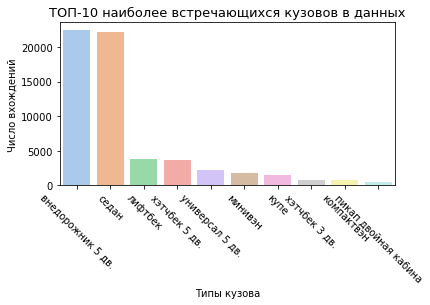

In [62]:
# Теперь посмотрим на кузова
num = 10
list_body_types = df.bodyType.value_counts()[:num].values

plt.figure(figsize=(6, 3))
plt.title(f"ТОП-{num} наиболее встречающихся кузовов в данных", fontsize=13)
sns.barplot(x=df.bodyType.value_counts()[:num].index, y=list_body_types, palette = "pastel")
plt.xticks(rotation='-45')
plt.xlabel("Типы кузова")
plt.ylabel("Число вхождений")
plt.show()

Как видно из графика, пятидверный внедорожник и седан наиболле встречаемые типы кузова.

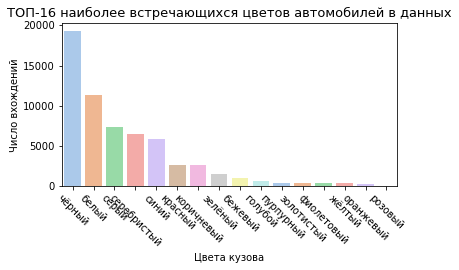

In [63]:
# Теперь посмотрим на кузова
num = df.color.nunique()
list_body_colors = df.color.value_counts()[:num].values

plt.figure(figsize=(6, 3))
plt.title(f"ТОП-{num} наиболее встречающихся цветов автомобилей в данных", fontsize=13)
sns.barplot(x=df.color.value_counts()[:num].index, y=list_body_colors, palette = "pastel")
plt.xticks(rotation='-45')
plt.xlabel("Цвета кузова")
plt.ylabel("Число вхождений")
plt.show()

In [72]:
print(f'{train.color.value_counts().index[0]} и {train.color.value_counts().index[1]} \
самые популярные цвета, а {train.color.value_counts().index[-1]} самый редкий.') 

чёрный и белый самые популярные цвета, а розовый самый редкий


## Мультимодальная визуализация данных  

Цель - обнаружить завивсимости в признаках.

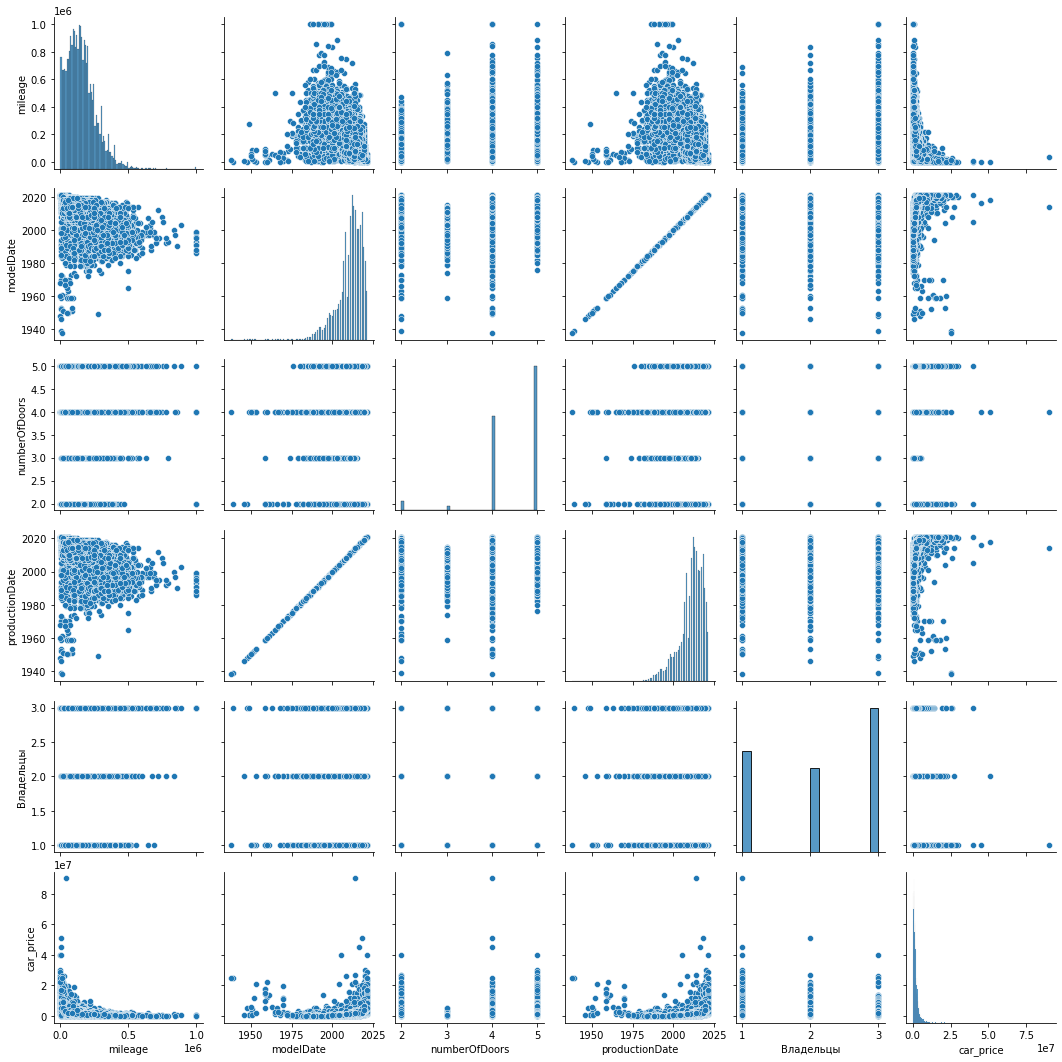

In [73]:
sns.pairplot(train.loc[:, list_num + ['car_price']])
plt.show()

Матрица графиков показала нам:
1. Обратная (негативная) зависимость прайса от пробега автомобиля  
2. Прямая зависимость между прайсом и годом модели (равно как и годом выпуска автомобиля, наконец здесь видно моё раннее предположение, что они линейно зависимы друг от друга)  
3.  Еще видно, что у новых автомобилей пробеги больше чем у старых, это видимо объясняется что такие автомобили у фанатов сохранились в хорошем состоянии и пробег у них маленький именно поэтому.

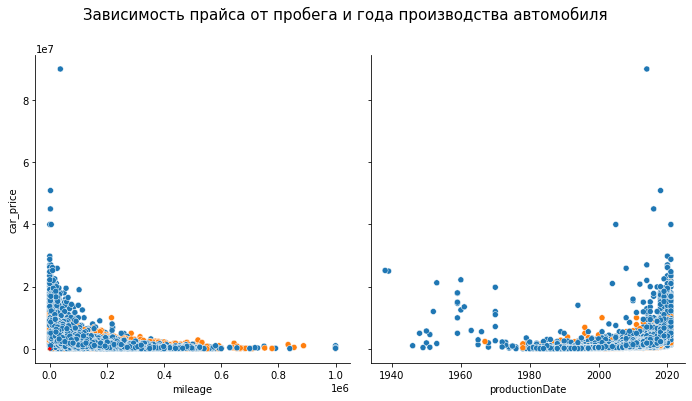

In [74]:
g = sns.PairGrid(data=train,
                 x_vars=['mileage', 'productionDate'],
                 y_vars=['car_price'],
                 hue='vendor',
                 height=5)

g.map(sns.scatterplot);

# Устанавливаем общий заголовок
g.fig.suptitle('Зависимость прайса от пробега и года производства автомобиля',
               y = 1.1,
               fontsize = 15)


g.axes[0, 0].plot([30, 60], [2500, 6000], c='r', lw=3);

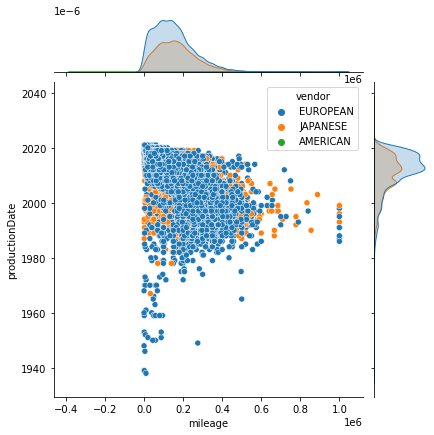

In [75]:
sns.jointplot(data=train,
              x='mileage',
              y='productionDate',
              hue='vendor');

Вывод получился такой:  
- Европейские автомобили имеют меньший пробег при том, что их продают быстрее (меньше время владения) и при этом их стоимость значительно выше японских автомобилей

In [76]:
# Проверим предположения матрицей корреляции
corr_matrix = train.loc[:, list_num + ['car_price']].corr(method='spearman')
display(corr_matrix)

,mileage,modelDate,numberOfDoors,productionDate,Владельцы,car_price
mileage,1.000000,-0.771204,-0.122304,-0.771204,0.519932,-0.690431
modelDate,-0.771204,1.000000,0.184935,1.000000,-0.589679,0.785987
numberOfDoors,-0.122304,0.184935,1.000000,0.184935,-0.184403,0.178766
productionDate,-0.771204,1.000000,0.184935,1.000000,-0.589679,0.785987
Владельцы,0.519932,-0.589679,-0.184403,-0.589679,1.000000,-0.461341
car_price,-0.690431,0.785987,0.178766,0.785987,-0.461341,1.000000


Выводы:  
1. Сильная прямая зависимость прайса от года модели (как и от года производства);  
2. Обратная зависимость от числа владельцев (тут же мы видим, что чем больше владельцев, тем больше возраст автомобиля);  
3. Также сильная обратная зависимость от пробега (больше пробег -> меньше стоимость)

## Посмотрим на взаимосвязи целевого признака и бинарными признаками

In [87]:
# from sklearn import preprocessing
# list_bin

In [88]:
# le = preprocessing.LabelEncoder()

# dh = df.copy()
# dh['ПТС'] = le.fit_transform(dh['ПТС'])
# dh['Руль'] = le.fit_transform(dh['Руль'])

# sns.jointplot(data=dh, x='ПТС', y='Руль', hue='vendor');

In [89]:
# сначала посмотрим на число праворульных автомобилей
df.groupby(['Руль','vendor'])['brand'].agg({'count'}).stb.subtotal()

count
Руль        vendor                  
левый       EUROPEAN           36944
            JAPANESE           21514
            левый - subtotal   58458
правый      EUROPEAN              10
            JAPANESE            2311
            правый - subtotal   2321
grand_total                    60779

Как и ожидалось в данных большинство автомобилей леворульные, интересно, что есть европейские праворульные автомобили.

In [98]:
# надо и в этих наборах изменить vendor
train.vendor = train.vendor.replace('AMERICAN','EUROPEAN')
test.vendor = test.vendor.replace('AMERICAN','EUROPEAN')

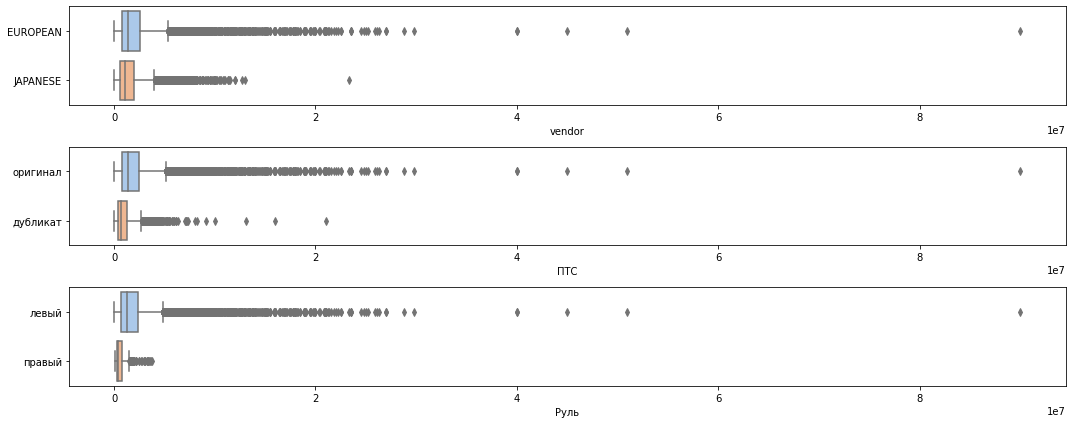

In [99]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 6))

for i, col in enumerate(list_bin):
    ax = axes[i]
#     sns.boxplot(y=col, x='car_price', data=train[train['car_price']<200000], ax=ax, palette = "pastel")
    sns.boxplot(y=col, x='car_price', data=train, ax=ax, palette = "pastel")
    ax.set_xlabel(col)
    ax.set_ylabel("")
fig.tight_layout()
plt.show()

Замеченные инсайты:
1. Европейские автомобили дороже японских (и разброс предложений также больше), и предложений более 200000 много больше японских;
2. Автомобили с оригинальным ПТС стоят больше, чем с дубликатом;
3. (это я уже подмечал) На рынке в основном предложены леворульные машины.

In [105]:
# как видно нам надо поработать с наименованием топлива
# оставлю только первый тип топлива, тк он основной.
train['fuelType'] = train['fuelType'].apply(lambda x: x.split(',')[0])
test['fuelType'] = test['fuelType'].apply(lambda x: x.split(',')[0])

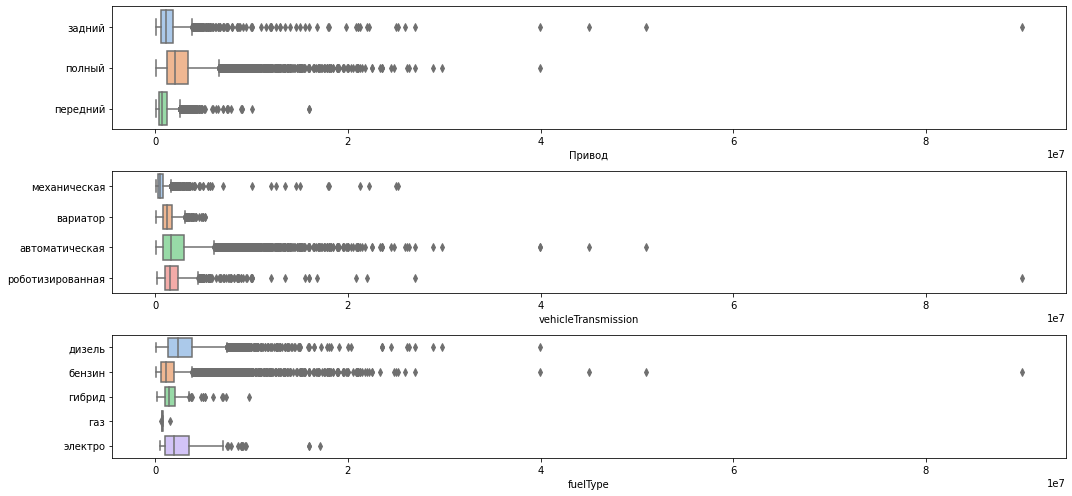

In [107]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 7))

for i, col in enumerate(list_cat):
    ax = axes[i]
#     sns.boxplot(y=col, x='car_price', data=train[train['car_price']<200000], ax=ax, palette = "pastel")
    sns.boxplot(y=col, x='car_price', data=train, ax=ax, palette = "pastel")
    ax.set_xlabel(col)
    ax.set_ylabel("")
fig.tight_layout()
plt.show()

Замеченные инсайты:
1. Автомобили с полным приводом дороже чем заднеприводные, а самые дешевые переднеприводные;
2. Автомобили с автоматом дороже всех, механика - самый дешевый вариант;
3. И бензиновые автомобили самы дешевые, однако имеют средный разброс по цене, и у них очень много "выбросов", включая самы большые цены на автомобили в сете.

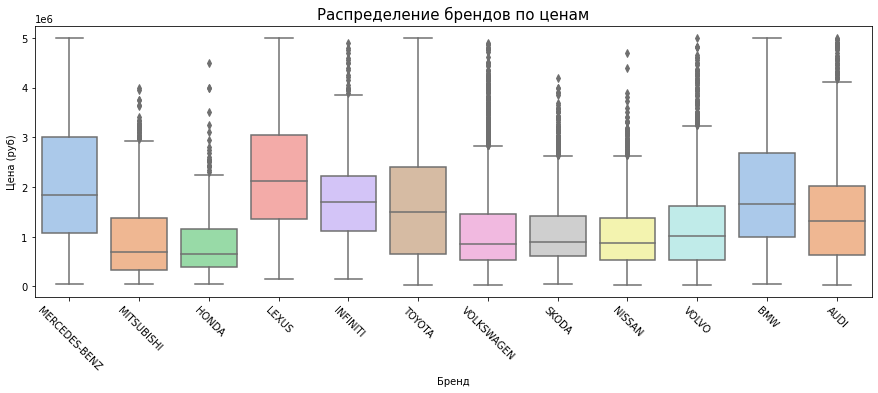

In [306]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

plt.figure(figsize=(15, 5))
sns.boxplot(x="brand", y="car_price", data=train[train['car_price']<5000000], palette = "pastel")
plt.title("Распределение брендов по ценам", fontsize=15)
plt.xticks(rotation='-45')
plt.xlabel('Бренд')
plt.ylabel('Цена (руб)')
plt.show()

ПС! Пришлось ограничить цену предложения 5млн, так как оказалось много выбросов и график получился неинформативным и неанализируемым.

Замеченный инсайт: самые дорогие бренды Mercedes, Lexus и BMW, самыми дешевыми Honda и Mistubishi.

Поскольку я ограничил выборку прайсом - посмотрим на статистику

In [320]:
train.groupby(['brand'])['car_price'].agg({'count','max','min','mean'}).astype('int').T

brand,AUDI,BMW,HONDA,INFINITI,LEXUS,MERCEDES-BENZ,MITSUBISHI,NISSAN,SKODA,TOYOTA,VOLKSWAGEN,VOLVO
mean,1820543,2514138,826238,1902134,2954970,3245306,939674,1024959,1100222,1909204,1149323,1317534
max,25200000,90000000,4500000,7897000,23300000,50900000,10000000,9990000,4200000,11500000,8500000,6950000
count,1829,3378,751,585,852,4717,1822,2799,1915,3012,3530,903
min,32000,60000,45000,155000,148000,49000,44444,35000,45000,30000,35000,40000


Как видно из статистики, у нас есть как минимум четыре предложения колосально выбивающихся из набора данных. Они у BMW (90млн), Mercedes (почти 51млн) и Audi (более 25 млн)

In [197]:
def num_20mln_above(s):
    # k - параметр отсечки по прайсу
    k = 20000000
    try:
        res = len([i for i in s if i > k])
    except:
        res = 0

    return res


def num_30mln_above(s):
    # k - параметр отсечки по прайсу
    k = 30000000
    try:
        res = len([i for i in s if i > k])
    except:
        res = 0

    return res


def num_40mln_above(s):
    # k - параметр отсечки по прайсу
    k = 40000000
    try:
        res = len([i for i in s if i > k])
    except:
        res = 0

    return res


def num_50mln_above(s):
    # k - параметр отсечки по прайсу
    k = 50000000
    try:
        res = len([i for i in s if i > k])
    except:
        res = 0

    return res


def num_1_3mln(s):
    # k - параметр отсечки по прайсу
    k1 = 1000000
    k2 = 3000000
    try:
        res = len([i for i in s if (i >= k1 and i < k2)])
    except:
        res = 0

    return res


def num_3_5mln(s):
    # k - параметр отсечки по прайсу
    k1 = 3000000
    k2 = 5000000
    try:
        res = len([i for i in s if (i >= k1 and i < k2)])
    except:
        res = 0

    return res


def num_5_10mln(s):
    # k - параметр отсечки по прайсу
    k1 = 5000000
    k2 = 10000000
    try:
        res = len([i for i in s if (i >= k1 and i < k2)])
    except:
        res = 0

    return res

def num_10_20mln(s):
    # k - параметр отсечки по прайсу
    k1 = 10000000
    k2 = 20000000
    try:
        res = len([i for i in s if (i >= k1 and i < k2)])
    except:
        res = 0

    return res

def num_h_1mln(s):
    # k - параметр отсечки по прайсу
    k1 = 500000
    k2 = 1000000
    try:
        res = len([i for i in s if (i >= k1 and i < k2)])
    except:
        res = 0

    return res


def num_250_500ths(s):
    # k - параметр отсечки по прайсу
    k1 = 250000
    k2 = 500000
    try:
        res = len([i for i in s if (i >= k1 and i < k2)])
    except:
        res = 0

    return res


def num_100_250ths(s):
    # k - параметр отсечки по прайсу
    k1 = 100000
    k2 = 250000
    try:
        res = len([i for i in s if (i >= k1 and i < k2)])
    except:
        res = 0

    return res


def num_100ths_less(s):
    # k - параметр отсечки по прайсу
    k = 100000
    try:
        res = len([i for i in s if (i < k)])
    except:
        res = 0

    return res

In [145]:
num_20mln_above()

MERCEDES-BENZ    35
BMW               2
AUDI              1
LEXUS             1
Name: brand, dtype: int64

In [183]:
# def num_20mln_above2(s):
#     try:
#         res = train[(train['car_price']>20000000) & (train['brand']==s)]['brand'].count()
#         if res==[]:
#             res=0
#     except:
#         res=0
    
#     return res

# num_20mln_above2('BMW')

In [286]:
agg_func_custom_count2 = {
    'car_price': [num_100ths_less, num_100_250ths, num_250_500ths, num_h_1mln,
                  num_1_3mln, num_5_10mln, num_10_20mln,
                  num_20mln_above, num_30mln_above, num_40mln_above, num_50mln_above]
}
dh = train.groupby(['brand']).agg(agg_func_custom_count2)
dh.columns = dh.columns.droplevel(0)

# загруппируем данные, для построения графика
data = []
for col in dh.columns:
    for ind in dh.index:
        data.append([ind, col, dh.loc[ind, col]])

# соберем в датафрейм
data = pd.DataFrame(data, columns={'c1', 'c2', 'c3'})
data.rename(columns={'c1': 'brand',
                     'c3': 'group',
                     'c2': 'value',
                     }, inplace=True)

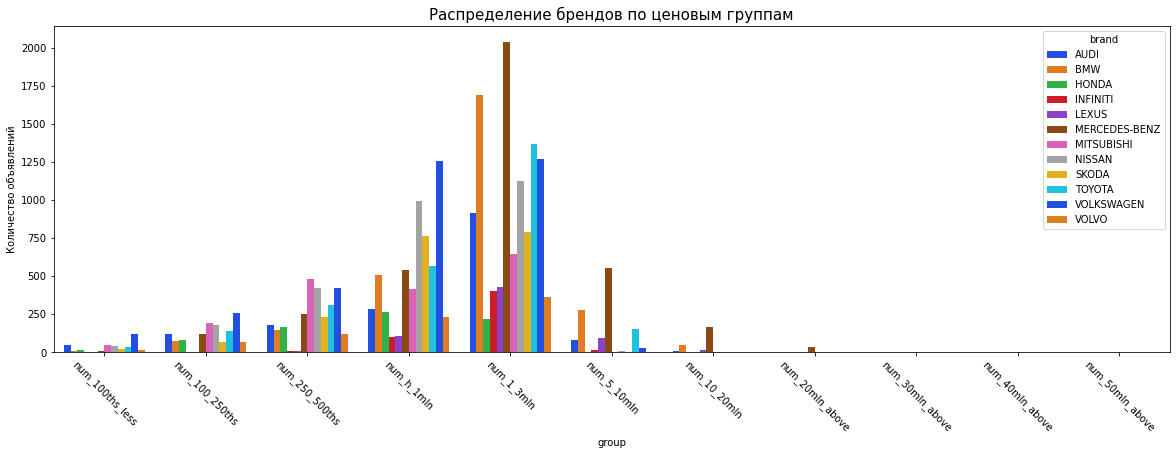

Распределение брендов по ценовым группам


brand,AUDI,BMW,HONDA,INFINITI,LEXUS,MERCEDES-BENZ,MITSUBISHI,NISSAN,SKODA,TOYOTA,VOLKSWAGEN,VOLVO
num_100ths_less,50,6,15,0,0,7,49,45,19,34,121,18
num_100_250ths,118,75,82,2,3,122,191,178,65,143,258,69
num_250_500ths,183,147,167,8,8,254,481,421,231,308,426,123
num_h_1mln,287,511,263,100,109,539,419,994,764,568,1260,230
num_1_3mln,916,1693,218,404,430,2041,648,1125,791,1371,1270,366
num_5_10mln,82,278,0,15,96,555,0,10,0,155,28,5
num_10_20mln,11,46,0,0,13,166,1,0,0,5,0,0
num_20mln_above,1,2,0,0,1,35,0,0,0,0,0,0
num_30mln_above,0,1,0,0,0,4,0,0,0,0,0,0
num_40mln_above,0,1,0,0,0,2,0,0,0,0,0,0


Число объявлений, максимальный, минимальный, средний и медианный прайсы


brand,AUDI,BMW,HONDA,INFINITI,LEXUS,MERCEDES-BENZ,MITSUBISHI,NISSAN,SKODA,TOYOTA,VOLKSWAGEN,VOLVO
count,1829.0,3378.0,751.0,585.0,852.0,4717.0,1822.0,2799.0,1915.0,3012.0,3530.0,903.0
max,25200000.0,90000000.0,4500000.0,7897000.0,23300000.0,50900000.0,10000000.0,9990000.0,4200000.0,11500000.0,8500000.0,6950000.0
min,32000.0,60000.0,45000.0,155000.0,148000.0,49000.0,44444.0,35000.0,45000.0,30000.0,35000.0,40000.0
mean,1820544.0,2514139.0,826238.0,1902134.0,2954970.0,3245306.0,939675.0,1024959.0,1100222.0,1909205.0,1149324.0,1317534.0
median,1385000.0,1800000.0,650000.0,1745000.0,2320500.0,2250000.0,696000.0,880000.0,900000.0,1600000.0,860000.0,1040000.0


In [302]:
# построим теперь график
plt.figure(figsize=(20, 6))
sns.barplot(x="group", y="value", hue="brand", data=data, palette="bright")
plt.title("Распределение брендов по ценовым группам", fontsize=15)
plt.xticks(rotation='-45')
plt.ylabel("Количество объявлений")
plt.show()

print("Распределение брендов по ценовым группам")
display(dh.T)

agg_func_custom_count = {'car_price': ['count', 'max', 'min','mean','median']}
print("Число объявлений, максимальный, минимальный, средний и медианный прайсы")
dy=train.groupby(['brand']).agg(agg_func_custom_count)
dy.columns=dy.columns.droplevel(0)
display(round(dy,0).T)

В общем то выводы здесь получаются аналогичные графику boxplot-а.  

ПС. На следующих признаках буду ограничиваться только boxplot-ом.

<b>Посмотрим на типы кузова</b>

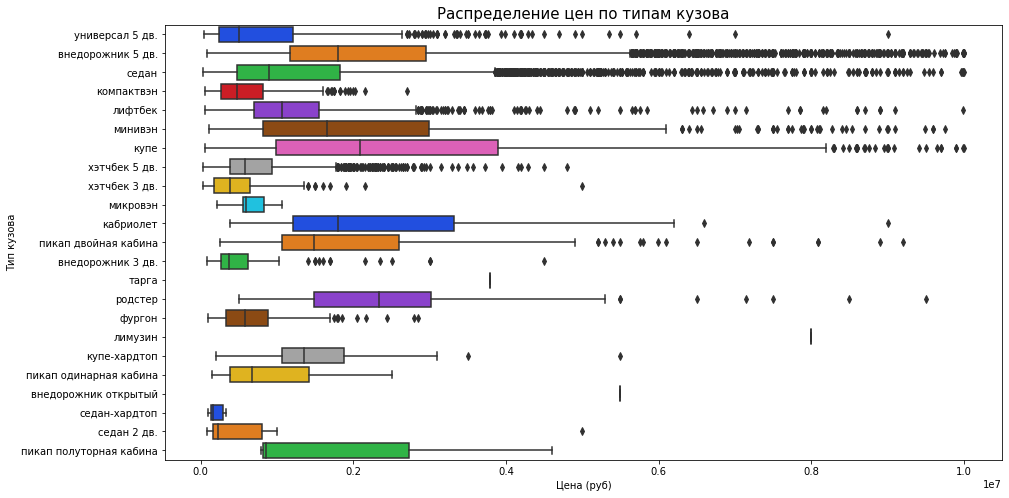

In [311]:
plt.figure(figsize=(15, 8))
sns.boxplot(y='bodyType', x="car_price",
            data=train[train['car_price'] < 10000000], palette="bright")
plt.title("Распределение цен по типам кузова", fontsize=15)
# plt.xticks(rotation='90')
plt.ylabel('Тип кузова')
plt.xlabel('Цена (руб)')
plt.show()

ПС. Пришлось ограничить выборку по стоимости, оставил все менее 10млн рублей.

Инсайды:
1. Самые дорогие кузова: лимузин,внедорожник открытый и купе
2. Самые дешевые седан-хардтоп и хэтчбек 3дв.
3. Самые большие разбросы у купе, кабриолета и минивэна

<b>Посмотрим на влияние цветов кузова на стоимость</b>

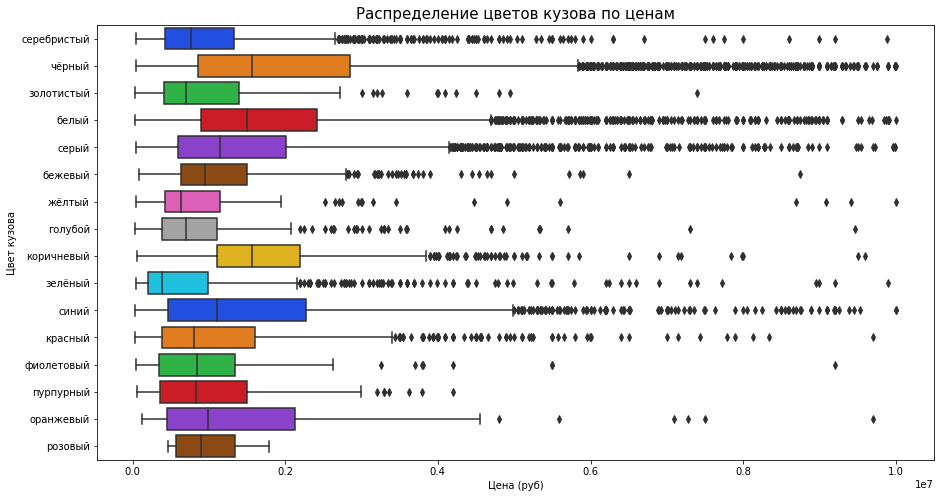

In [334]:
plt.figure(figsize=(15, 8))
sns.boxplot(y='color', x="car_price",
            data=train[train['car_price'] < 10000000], palette="bright")
plt.title("Распределение цветов кузова по ценам", fontsize=15)
# plt.xticks(rotation='90')
plt.ylabel('Цвет кузова')
plt.xlabel('Цена (руб)')
plt.show()

ПС. Пришлось ограничить выборку по стоимости, оставил все менее 10млн рублей.

Инсайды:
1. Самые дорогие цвета: чёрный, белый и синий
2. Самые дешевые зеленый и фиолетовый
3. Самые большие разбросы у чёрного, синего и оранжевого.

In [328]:
# train.enginePower.split(' ')[0].sample(5)
try:
    train['enginePower'] = train['enginePower'].apply(lambda x: x.split(' ')[0])
    train['enginePower'] = train['enginePower'].astype('int')
except:
    pass

try:
    test['enginePower'] = test['enginePower'].apply(lambda x: x.split(' ')[0])
    test['enginePower'] = test['enginePower'].astype('int')
except:
    pass

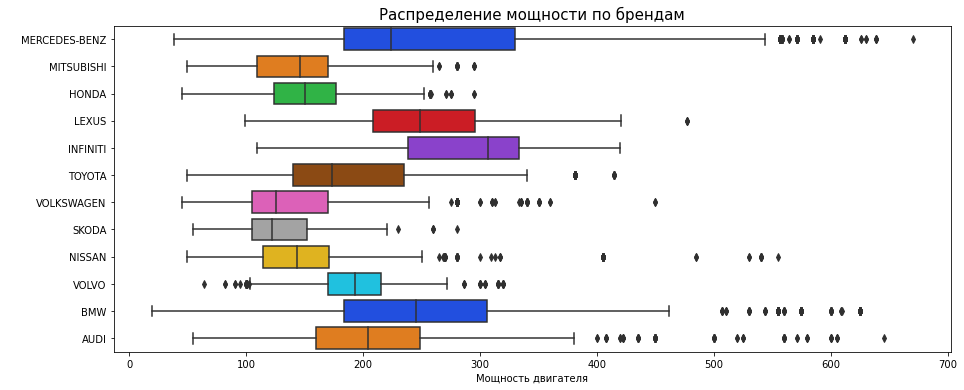

In [333]:
plt.figure(figsize=(15, 6))
sns.boxplot(y='brand', x="enginePower",
            data=train, palette="bright")
plt.title("Распределение мощности по брендам", fontsize=15)
# plt.xticks(rotation='90')
plt.ylabel(' ')
plt.xlabel('Мощность двигателя')
plt.show()

Инсайды:
1. К трем самым дорогим брендам (Mercedes, BMW и Audi) здесь неожиданно добавился Infinity. Скорее всего это связано с тем, что Infinity входит в группу с Nissan и является премиальным брендом группы, соответственно и двигатели устанавливают на них большие и мощные.
2. У Mercedes и BMW самые большие разбросы по мощности двигателей, скорее всего это связано с большими модельными линейками. У этих брендов нет суббрендов.
3. Самые слабые двигатели стоят в автомобилях Skoda.

<b>Вернемся к оценке влияния признаков на целевой признак</b>  

Посмотрим на зависимость цены от типа топлива и типа коробки передач

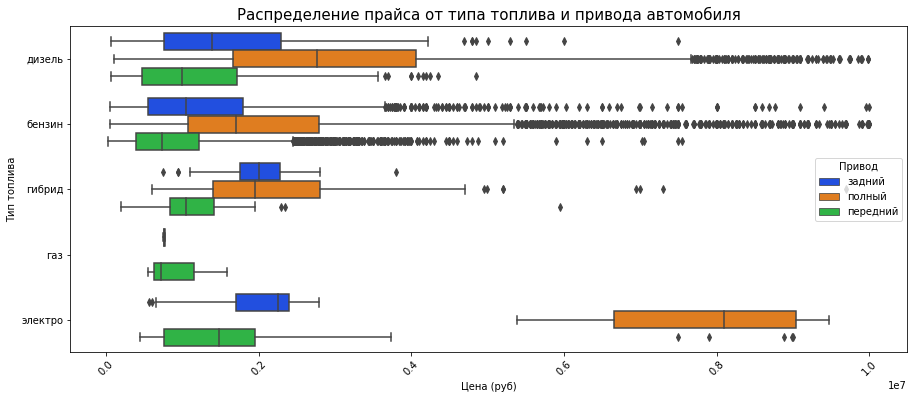

In [339]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation='45')
ax = sns.boxplot(y="fuelType", x="car_price", hue='Привод',
                 data=train[train['car_price'] < 10000000], palette="bright")
ax.set(ylabel='Тип топлива', xlabel='Цена (руб)')
ax.set_title(
    'Распределение прайса от типа топлива и привода автомобиля', fontsize=15)
plt.show()

Инсайды:  
1. Как я уже отмечал ранее, переднеприводные автомобили везде самые дешевые (вне зависимости от типа используемого топлива).  
2. Самые дорогие - полноприводные автомобили.

<b>Посмотрим на распределение цен на 20 наиболее встречающихся моделей</b>  


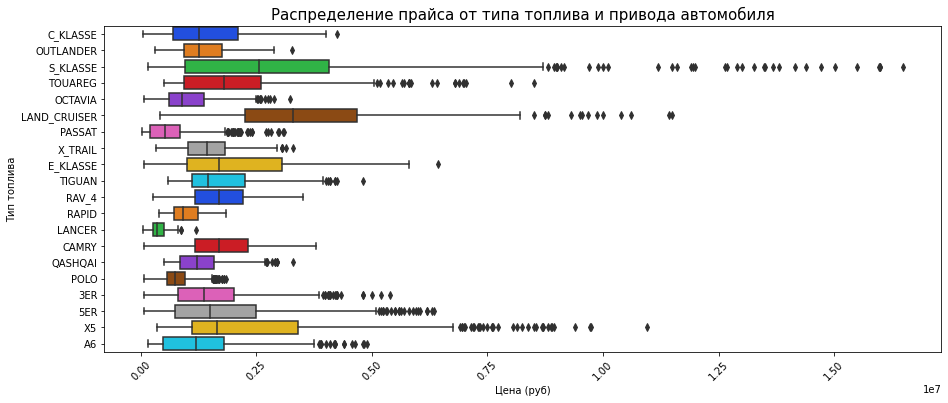

In [355]:
list_most_freq_models = train.model_name.value_counts()[:20].index
dj = train[train['model_name'].isin(list_most_freq_models)]

plt.figure(figsize=(15, 6))
plt.xticks(rotation='45')
ax = sns.boxplot(y="model_name", x="car_price",
                 data=dj, palette="bright")
ax.set(ylabel='Тип топлива', xlabel='Цена (руб)')
ax.set_title(
    'Распределение прайса от типа топлива и привода автомобиля', fontsize=15)
plt.show()

Инсайды (из 20-ти самых часто встречающихся объявлений в спарсенной БД):
1. Неожиданно Land Cruiser оказался самой дорогой машиной. На 2-м и 3-м месте - S-класс и X5.
2. Самый большой разброс цен снова у этой же троицы.
3. Самым дешевым оказались passat и lancer.

In [361]:
dj.groupby(['brand','model_name'])['car_price'].agg({'count','max','min','mean'}).astype('int')

mean       max  count     min
brand         model_name                                    
AUDI          A6            1298339   4900000    352  160000
BMW           3ER           1563522   5400000    530   60000
              5ER           1810117   6350000    727   60000
              X5            2545258  10949826    486  350000
MERCEDES-BENZ C_KLASSE      1431407   4250000    469   49000
              E_KLASSE      2020757   6424000    873   80000
              S_KLASSE      3309369  16500000    510  155000
MITSUBISHI    LANCER         385202   1200000    434   45000
              OUTLANDER     1339569   3270000    457  300000
NISSAN        QASHQAI       1278260   3300000    456  500000
              X_TRAIL       1460604   3299000    520  325000
SKODA         OCTAVIA       1004534   3230727    882   76000
              RAPID          965495   1850000    333  385000
TOYOTA        CAMRY         1736953   3800000    619   60000
              LAND_CRUISER  3668825  11500000    438  420000
              RAV_4         1726458   3499000    415  260000
VOLKSWAGEN    PASSAT         659899   3100000    582   37000
              POLO           799752   1849000    672   75000
              TIGUAN        1730088   4800088    543  590000
              TOUAREG       2109960   8500000    327  500000

Опять сделал группировку и снова понял, что выводы по ней аналогичные графику box-плота.

<b>Посмотрим на распределение цен в зависимости от года производства</b>  


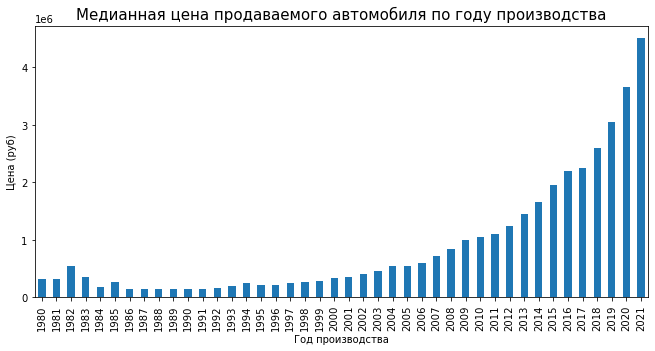

In [377]:
plt.figure(figsize=(11, 5))
train[(train['car_price'] < 20000000) & (train['productionDate'] >= 1980)
      ].groupby('productionDate')['car_price'].median().plot(kind='bar')
plt.title("Медианная цена продаваемого автомобиля по году производства", fontsize=15)
plt.xticks(rotation='90')
plt.xlabel('Год производства')
plt.ylabel('Цена (руб)')
plt.show()

Основные выводы по наибольшему влиянию на цену производят:
1. Среди числовых признаков: год производства, пробег и мощность двигателя (productionDate, mileage и enginePower)
2. Среди категорийных признаков: бренд, модель и тип топлива (brand, model_name и fuelType)

<p style="color:green">#############################################################################################</p><br>
<font size="5">  
<a id='p_4' style="color:blue">4. Строим "наивную" модель</a></font> 

[назад к оглавлению](#chapters) | [предыдущая часть](#p_3) | [следующая часть](#p_5)

Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). C ней будем сравнивать другие модели.  

разделяем данные обратно на test и train и моделируем

In [378]:
X = train.copy().drop('sample', 1)
y = X.pop('car_price')

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, shuffle=True, random_state=42)

In [379]:
tmp_train = X_train.copy()
tmp_train['car_price'] = y_train

# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['car_price'].median())
# predict = X_test['name'].map(tmp_train.groupby('name')['car_price'].median())

# считаем точность
res= round((mape(y_test, predict.values))*100,2)
print(f"Точность наивной модели по метрике MAPE: {res:0.2f}%")

# Точность наивной модели по метрике MAPE: 31.07% (по полю "name")

# Точность наивной модели по метрике MAPE: 99.04% (по полю "engineDisplacement")

Точность наивной модели по метрике MAPE: 99.04%


<p style="color:green">#############################################################################################</p><br>
<font size="5">  
<a id='p_5' style="color:blue">5. Добавляем новые признаки</a></font> 

[назад к оглавлению](#chapters) | [предыдущая часть](#p_4) | [следующая часть](#p_6)

In [439]:
# я заготовил целую кучу функций для упрощения переподготовки данных для моделирования
# запускаем по очереди

# загрузка из исходного файла
df_comp = get_read()

# исправление ошибок, исключение уже проданных машин и добавление новых признаков
df_comp = get_new_features(df_comp)

# добавляем еще признаки
df_comp = get_new_features_2(df_comp)

# конвертируем признаки в числовые поля
df_comp = convert_to_numbers(df_comp)

# удаляем лишние признаки
df_comp = clear_dataset(df_comp)

2021-12-07 16:50:05.575219 - исходные данные загружены
2021-12-07 16:50:06.599525 --- перезагрузили тестовую базу
2021-12-07 16:50:06.876693 --- в train удалены лишние признаки (начинающиеся на "z_"
2021-12-07 16:50:06.926559 --- объединены наборы test и train в df
2021-12-07 16:50:07.270271 --- в df созданы признаки "_is_filled"
2021-12-07 16:50:07.270271 --- в df заменяем пропуски на mode по признаку
2021-12-07 16:50:07.454267 --- в df пропуски заполнены
2021-12-07 16:50:07.512102 --- в df создан признак "mileage_group"
2021-12-07 16:50:07.535016 --- в df создан признак "modelDate_group"
2021-12-07 16:50:08.046160 --- в df создан признак "engine_volume"
2021-12-07 16:50:08.366218 --- в df создан признак "engine_power"
2021-12-07 16:50:08.387839 --- в df создан признак "engine_volume"
2021-12-07 16:50:08.419632 --- в df создан признак "engine_power_group"
2021-12-07 16:50:10.311954 --- в df создан признак "super_gen_group"
2021-12-07 16:50:10.343190 --- в df перевели признак "Владельц

In [489]:
# проанализируем значимость категориальных признаков
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif

# загрузка из исходного файла
df_comp_imp = get_read()
# исправление ошибок, исключение уже проданных машин и добавление новых признаков
df_comp_imp = get_new_features(df_comp_imp)
# добавляем еще признаки
df_comp_imp = get_new_features_2(df_comp_imp)
# конвертируем признаки в числовые поля
df_comp_imp = convert_to_numbers(df_comp_imp)

# удаляем лишние признаки
df_comp_imp = clear_dataset(df_comp_imp)

df_comp_imp = df_comp_imp[df_comp_imp['sample'] == 1]


2021-12-07 18:04:31.387284 - исходные данные загружены
2021-12-07 18:04:32.408255 --- перезагрузили тестовую базу
2021-12-07 18:04:32.708196 --- в train удалены лишние признаки (начинающиеся на "z_"
2021-12-07 18:04:32.757988 --- объединены наборы test и train в df
2021-12-07 18:04:33.073089 --- в df созданы признаки "_is_filled"
2021-12-07 18:04:33.073089 --- в df заменяем пропуски на mode по признаку
2021-12-07 18:04:33.276135 --- в df пропуски заполнены
2021-12-07 18:04:33.334161 --- в df создан признак "mileage_group"
2021-12-07 18:04:33.359079 --- в df создан признак "modelDate_group"
2021-12-07 18:04:33.884842 --- в df создан признак "engine_volume"
2021-12-07 18:04:34.193879 --- в df создан признак "engine_power"
2021-12-07 18:04:34.212097 --- в df создан признак "engine_volume"
2021-12-07 18:04:34.243373 --- в df создан признак "engine_power_group"
2021-12-07 18:04:36.117158 --- в df создан признак "super_gen_group"
2021-12-07 18:04:36.164018 --- в df перевели признак "Владельц

In [499]:
# list_cat2=list(df_comp_imp.select_dtypes(['object']).columns)
list_cat2 = ['bodyType', 'brand', 'color', 'model_name',\
             'vehicleTransmission', 'ПТС', 'Привод', 
             'Руль', 'numberOfDoors', 'fuelType', 'Владельцы']

<AxesSubplot:>

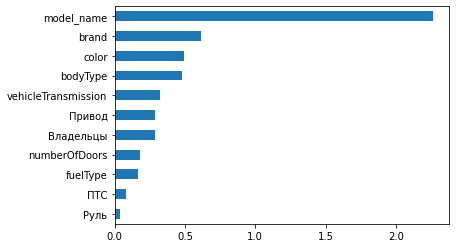

In [500]:
imp_cat = Series(mutual_info_classif(df_comp_imp[list_cat2], 
                                     df_comp_imp['car_price'], 
                                     discrete_features=True), index=list_cat2)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind='barh')

In [440]:
# Проверим наши признаки, что они все числовые

k=0
list_to_work=[]

# здесь проверяем
for item in df_comp.columns:
    if df_comp[item].dtypes not in ["int64","float"]:
            list_to_work.append(item)
            k+=1

# выводим результат проверки
if k==0:
    print('у всех признаков форматы числовые)))')
else:
    print('есть над чем поработать!!!!')
    print('разные форматы:')
#     print(list_to_work)
    for item in list_to_work:
        print(item,'\t',df_comp[item].dtypes)

у всех признаков форматы числовые)))


### Пробуем построить другие модели

In [441]:
df_scl=df_comp.copy()

In [442]:
from sklearn.preprocessing import RobustScaler

X = df_scl.drop(['sample','car_price','sell_id'], 1)
columns_names = set(X.columns.to_list()) - set(['car_price','sell_id'])
columns_names
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=columns_names)

X_scaled.describe()

,median_power_fuel_type,median_mileage_model,description_is_filled,car_older_3_years,top_colors,fuelType,power_volume,bodyType,mileage,equipment_dict_is_filled,median_power_model_name,vehicleTransmission,modelDate_group,median_mileage_body_type,image_is_filled,numberOfDoors,car_older_5_years,brand_fuel_type,car_age,brand_production_year,top_bodyType,vendor,mileage_group,months_owning,brand_drive_type,fuel_drive_type,Руль,model_age,complectation_dict_is_filled,productionDate,offers_dict_is_filled,Владельцы,Владельцы_is_filled,Привод,engine_volume_group,Таможня_is_filled,super_gen_group,median_power_brand,rare_colors,median_power_body_type,engine_power_group,rare_bodyType,Владение_is_filled,top_door_num,brand_body_type,miles_in_year,color,description_length,ПТС,model_name,median_power_drive,brand
count,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000,60779.000000
mean,0.574524,-0.036230,0.207062,-0.164860,0.102266,0.355463,-0.538327,-0.134701,-0.381201,0.392093,0.081525,0.137942,0.302374,0.038188,-0.465095,-0.012027,-0.164465,-0.027296,0.405617,-0.000033,-0.290989,-0.000016,0.322504,0.453018,0.633706,0.037052,-0.098554,0.213222,9.126508,0.192517,0.143045,0.190183,4.601310,-0.039965,0.146717,0.333015,0.183791,0.164507,0.527116,0.088526,0.134701,0.147483,-0.005088,-0.009667,0.106999,-0.124813,-0.228335,-0.267362,0.001448,-0.171293,0.029319,-0.054377
std,2.604881,0.519240,0.910294,0.423955,0.802957,0.738629,0.709064,0.915062,0.924322,0.488322,0.421619,0.344842,0.675792,0.191650,0.498784,0.109008,0.370700,0.162945,0.491015,0.005736,0.454222,0.004056,0.946881,0.837702,0.777558,0.510092,0.908239,0.575128,29.764436,0.890595,1.049713,0.814054,10.851226,0.468303,0.551806,0.671824,0.656231,0.955194,1.512038,0.629336,0.915062,0.856696,0.925751,0.715478,0.948332,0.330509,0.419763,0.442587,0.038024,0.376768,0.168701,0.226763
min,-2.000000,-0.857143,-0.750000,-1.000000,-1.146862,-0.346734,-5.000000,-13.375000,-2.000000,0.000000,-0.500000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-0.524941,-1.000000,0.000000,-0.500000,-1.000000,-0.402395,-21.000000,-3.239838,-1.975000,-2.787500,-54.000000,-0.560748,-0.542169,-0.339286,-0.669856,-1.300000,-1.285714,-1.000000,-1.250000,-1.222222,-2.668304,-3.743590,-1.793138,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000
25%,-1.000000,-0.571429,-0.500000,0.000000,-0.472224,-0.206030,-1.000000,-0.500000,-1.000000,0.000000,-0.500000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-0.294537,0.000000,0.000000,-0.500000,-1.000000,-0.279542,0.000000,-0.328859,-0.462500,0.000000,0.000000,-0.560748,-0.313253,-0.160714,-0.368421,-0.500000,-0.428571,-0.500000,-0.500000,-0.444444,-0.543482,-0.615385,-0.468975,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.428571,0.500000,0.000000,0.527776,0

In [443]:
X_scaled['sample'] = df_comp['sample']
X_scaled['car_price'] = df_comp['car_price']

X_scaled.head()

,median_power_fuel_type,median_mileage_model,description_is_filled,car_older_3_years,top_colors,fuelType,power_volume,bodyType,mileage,equipment_dict_is_filled,median_power_model_name,vehicleTransmission,modelDate_group,median_mileage_body_type,image_is_filled,numberOfDoors,car_older_5_years,brand_fuel_type,car_age,brand_production_year,top_bodyType,vendor,mileage_group,months_owning,brand_drive_type,fuel_drive_type,Руль,model_age,complectation_dict_is_filled,productionDate,offers_dict_is_filled,Владельцы,Владельцы_is_filled,Привод,engine_volume_group,Таможня_is_filled,super_gen_group,median_power_brand,rare_colors,median_power_body_type,engine_power_group,rare_bodyType,Владение_is_filled,top_door_num,brand_body_type,miles_in_year,color,description_length,ПТС,model_name,median_power_drive,brand,sample,car_price
0,-2.0,-0.857143,-0.75,-1.0,1.594621,-0.346734,0.0,-1.375,-2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,-0.465558,2.0,0.0,0.0,-1.0,-0.402395,0.0,-0.854179,-0.2625,-0.5,27.0,0.000000,0.686747,-0.339286,-0.669856,-1.3,-1.285714,-1.0,1.375,1.111111,-0.204196,1.846154,0.394992,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1,250000
1,-1.0,-0.714286,-0.75,0.0,0.974054,-0.341709,0.0,0.125,-1.0,1.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.785036,1.0,1.0,0.0,-1.0,-0.402134,83.0,-0.093960,-0.3750,1.0,0.0,0.439252,-0.253012,-0.321429,-0.665072,-1.2,-1.142857,-0.5,-0.125,-0.222222,-0.347054,-0.615385,1.931074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1150000
2,0.0,-0.571429,-0.50,0.0,-0.651988,-0.336683,-1.0,0.125,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,-0.155582,0.0,1.0,-0.5,-1.0,-0.401874,0.0,0.182699,-0.4625,0.0,0.0,-0.560748,-0.240964,-0.303571,-0.660287,-1.1,-1.000000,0.0,-0.125,-0.222222,0.902946,0.384615,-0.924157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1200000
3,-1.0,-0.428571,-0.50,0.0,1.523923,-0.331658,0.0,-1.125,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,-0.287411,2.0,0.0,0.5,0.0,-0.401614,0.0,-0.375839,0.7625,1.0,0.0,0.439252,0.987952,-0.285714,-0.655502,-1.0,-0.857143,-0.5,1.125,0.888889,-0.382304,-0.615385,0.551735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,600000
4,0.0,-0.428571,-0.50,0.0,-0.062842,-0.326633,-1.0,-0.375,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.395487,0.0,0.0,0.0,0.0,-0.401353,37.0,0.385235,0.3875,0.0,0.0,0.000000,0.987952,-0.267857,-0.650718,-0.9,-0.857143,0.5,0.375,0.222222,0.385089,0.384615,-0.433506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1000000


In [444]:
df_comp=X_scaled.copy()

<AxesSubplot:>

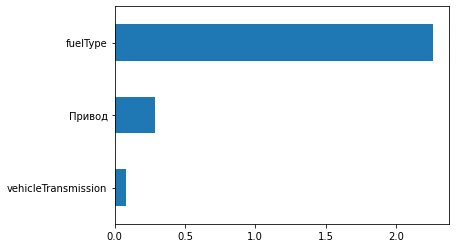

In [445]:
# разделяем наш датасет на тренировочный и тестовый
train = df_comp[df_comp['sample']==1].drop(['sample'], 1)
test = df_comp[df_comp['sample']==0].drop(['sample', 'car_price'], 1)

In [446]:
# зафиксируем параметр
RANDOM_SEED = 42

In [447]:
# из тренировочного набора выделяем X и y
X = train.drop('car_price', 1)
y = train.loc[:, 'car_price']

# разделяем на обучаемый и проверочные наборы данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=29)

# создам список для внесения результатов моделирования
# потом (в конце) будет легче сравнивать модели между собой
results_modelling=[]

In [448]:
# display(pd.DataFrame(results_modelling,columns=['Model','MAPE']))

In [449]:
# для начала посмотрим простую модель линейной регрессии
from sklearn.linear_model import LinearRegression

linear_regr = LinearRegression().fit(X_train, np.log(y_train+1))
y_pred = np.exp(linear_regr.predict(X_test))

# res=round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
res = round((mape(y_test, y_pred))*100, 2)

print(f"Точность модели LinearRegression по метрике MAPE: {res:0.2f}%")
results_modelling.append(['LinearRegression', res])

# Точность модели LinearRegression по метрике MAPE: 27.94%

# добавили признаков
# Точность модели LinearRegression по метрике MAPE: 25.58%

Точность модели LinearRegression по метрике MAPE: 25.58%


In [450]:
# теперь используем модель CatBoostRegressor

model = CatBoostRegressor(iterations=200, random_state=29)

model.fit(X_train, y_train, cat_features=None, plot=True)
y_pred = model.predict(X_test)

# res=round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
res=round((mape(y_test, y_pred))*100,2)
print(f"\nТочность модели CatBoostRegressor по метрике MAPE: {res:0.2f}%")
results_modelling.append(['CatBoostRegressor',res])

# Точность модели CatBoostRegressor по метрике MAPE: 21.53%
# Точность модели CatBoostRegressor по метрике MAPE: 19.78% (добавили признаков)
# Точность модели CatBoostRegressor по метрике MAPE: 19.40% (добавил масштабирование данных)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.242387
0:	learn: 1950779.6178241	total: 34.6ms	remaining: 6.88s
1:	learn: 1718262.5771060	total: 39ms	remaining: 3.86s
2:	learn: 1549457.0788772	total: 43.1ms	remaining: 2.83s
3:	learn: 1415596.8480004	total: 48.1ms	remaining: 2.35s
4:	learn: 1306305.8411888	total: 51.8ms	remaining: 2.02s
5:	learn: 1225562.9864148	total: 55.8ms	remaining: 1.8s
6:	learn: 1158129.7490953	total: 60ms	remaining: 1.65s
7:	learn: 1100411.7843957	total: 63.7ms	remaining: 1.53s
8:	learn: 1060818.1467474	total: 67.7ms	remaining: 1.44s
9:	learn: 1025491.3531162	total: 72.2ms	remaining: 1.37s
10:	learn: 983610.4051189	total: 77.1ms	remaining: 1.32s
11:	learn: 959035.3960146	total: 81.4ms	remaining: 1.27s
12:	learn: 942467.8375147	total: 84.8ms	remaining: 1.22s
13:	learn: 937512.7065686	total: 88.1ms	remaining: 1.17s
14:	learn: 935273.5320311	total: 91.6ms	remaining: 1.13s
15:	learn: 910522.8029990	total: 95.4ms	remaining: 1.1s
16:	learn: 897842.3747383	total: 99ms	remaining: 1.06s
17:	learn

146:	learn: 400888.5587014	total: 510ms	remaining: 184ms
147:	learn: 399586.6072847	total: 513ms	remaining: 180ms
148:	learn: 398640.8342542	total: 516ms	remaining: 177ms
149:	learn: 397607.5029864	total: 520ms	remaining: 173ms
150:	learn: 396409.1983648	total: 523ms	remaining: 170ms
151:	learn: 394572.1268543	total: 526ms	remaining: 166ms
152:	learn: 394512.4919260	total: 529ms	remaining: 163ms
153:	learn: 392990.7112814	total: 532ms	remaining: 159ms
154:	learn: 392007.8810432	total: 536ms	remaining: 156ms
155:	learn: 391228.5834716	total: 539ms	remaining: 152ms
156:	learn: 390165.9852643	total: 543ms	remaining: 149ms
157:	learn: 388627.4822664	total: 546ms	remaining: 145ms
158:	learn: 388123.7512067	total: 549ms	remaining: 142ms
159:	learn: 387334.4751819	total: 552ms	remaining: 138ms
160:	learn: 386446.3416526	total: 555ms	remaining: 134ms
161:	learn: 385277.6267536	total: 559ms	remaining: 131ms
162:	learn: 384556.4220048	total: 562ms	remaining: 128ms
163:	learn: 383806.9559454	tota

In [158]:
# # добавил гиперпараметров к CatBoostRegressor
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# model.fit(X_train, y_train,
#          eval_set=(X_test, y_test),
#          verbose_eval=0,
#          use_best_model=True
#          )

# model.save_model('catboost_single_model_baseline.model')
# predict = model.predict(X_test)

# # res=round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
# res=round((mape(y_test, y_pred))*100,2)
# print(f"\nТочность модели CatBoostRegressor (v2) по метрике MAPE: {res:0.2f}%")
# results_modelling.append(['CatBoostRegressor (v2)',res])

# # Точность модели CatBoostRegressor (v2) по метрике MAPE: 21.53%
# # Точность модели CatBoostRegressor (v2) по метрике MAPE: 19.78% (добавили признаков)

# Получается, что это вариант не вариант (результат аналогичен предыдущему) - искоючаю его из дальнейших вычислений.

In [451]:
# пробую с логарифмом
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

# model.save_model('catboost_single_model_2_baseline.model')
y_pred = np.exp(model.predict(X_test))

# res=round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
res=round((mape(y_test, y_pred))*100,2)
print(f"\nТочность модели CatBoostRegressor (v3) по метрике MAPE: {res:0.2f}%")
results_modelling.append(['CatBoostRegressor (v3)',res])

# Точность модели CatBoostRegressor (v3) по метрике MAPE: 14.64%
# Точность модели CatBoostRegressor (v3) по метрике MAPE: 13.87% (добавили признаков)
# Точность модели CatBoostRegressor (v3) по метрике MAPE: 13.94% (добавил масштабирование данных)


Точность модели CatBoostRegressor (v3) по метрике MAPE: 13.94%


In [452]:
# теперь модель ГрадиентногоБустинга
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(min_samples_split = 2,
                               learning_rate = 0.03,
                               max_depth = 10,
                               n_estimators = 1000)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

# res=round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
res=round((mape(y_test, y_pred))*100,2)
print(f"\nТочность модели GradientBoostingRegressor по метрике MAPE: {res:0.2f}%")
results_modelling.append(['GradientBoostingRegressor',res])

# Точность модели GradientBoostingRegressor по метрике MAPE: 17.17%
# Точность модели GradientBoostingRegressor по метрике MAPE: 16.52% (добавили признаков)
# Точность модели GradientBoostingRegressor по метрике MAPE: 16.46% (добавил масштабирование данных)


Точность модели GradientBoostingRegressor по метрике MAPE: 16.46%


In [1]:
# долго работает
# from sklearn.model_selection import GridSearchCV
# max_depth = [5,10,15]
# n_estimators = [100, 200, 1000]
# hyperparameters = dict(max_depth = max_depth, n_estimators = n_estimators)
# model = GradientBoostingRegressor()
# model.fit(X_train, y_train)
# clf = GridSearchCV(model, hyperparameters)
# best_model = clf.fit(X_train, y_train)
# print('max_depth: ', best_model.best_estimator_.get_params()['max_depth'])
# print('n_estimators: ', best_model.best_estimator_.get_params()['n_estimators'])

# max_depth:  5
# n_estimators:  1000

In [453]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 1000,
                           n_jobs = -1,
                           max_depth = 15,
                           max_features = 'log2',
                           random_state = RANDOM_SEED,
                           oob_score = True)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

# res=round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
res=round((mape(y_test, y_pred))*100,2)
print(f"\nТочность модели RandomForestRegressor по метрике MAPE: {res:0.2f}%")
results_modelling.append(['RandomForestRegressor',res])

# Точность модели RandomForestRegressor по метрике MAPE: 22.97%
# Точность модели RandomForestRegressor по метрике MAPE: 18.98% (добавили признаков)
# Точность модели RandomForestRegressor по метрике MAPE: 18.88% (добавил масштабирование данных)


Точность модели RandomForestRegressor по метрике MAPE: 18.88%


In [454]:
from lightgbm import LGBMRegressor
lgbmr = LGBMRegressor(objective = 'regression', 
                      max_depth = 10,
                      num_leaves = 500,
                      learning_rate = 0.05,
                      n_estimators = 10000,
                      metric = 'mape',
                      feature_fraction = 0.6
                      )
lgbmr.fit(X_train, y_train)
predict = lgbmr.predict(X_test)

# res=round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
res=round((mape(y_test, y_pred))*100,2)
print(f"\nТочность модели LGBMRegressor по метрике MAPE: {res:0.2f}%")
results_modelling.append(['LGBMRegressor',res])

# Точность модели LGBMRegressor по метрике MAPE: 22.97%
# Точность модели LGBMRegressor по метрике MAPE: 18.98% (добавили признаков)
# Точность модели LGBMRegressor по метрике MAPE: 18.88% (добавил масштабирование данных)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6

Точность модели LGBMRegressor по метрике MAPE: 18.88%


In [455]:
from sklearn.ensemble import StackingRegressor
estimators = [('lgbmr', LGBMRegressor(objective = 'regression', 
                                      max_depth = 10, 
                                      num_leaves = 500,
                                      learning_rate = 0.02, 
                                      n_estimators = 100, 
                                      metric = 'mape',
                                      feature_fraction = 0.6
                                     )
              ),
              ('gbr', GradientBoostingRegressor(min_samples_split = 2,
                                                learning_rate = 0.03,
                                                max_depth = 10,
                                                n_estimators = 100
                                               )
              )]

stack = StackingRegressor(estimators = estimators, final_estimator = LinearRegression())

stack.fit(X_train, np.log(y_train))
y_pred = np.exp(stack.predict(X_test))

# res=round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
res=round((mape(y_test, y_pred))*100,2)
print(f"\nТочность модели StackingRegressor по метрике MAPE: {res:0.2f}%")
results_modelling.append(['StackingRegressor',res])

# Точность модели StackingRegressor по метрике MAPE: 15.92%
# Точность модели StackingRegressor по метрике MAPE: 14.81% (добавили признаков)
# Точность модели StackingRegressor по метрике MAPE: 14.84% (добавил масштабирование данных)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6

Точность модели StackingRegressor по метрике MAPE: 14.84%


In [456]:
import xgboost as xgb
xgbr = xgb.XGBRegressor(objective = 'reg:squarederror',
                        colsample_bytree = 0.5,
                        learning_rate = 0.02,
                        max_depth = 10,
                        alpha = 1,
                        n_jobs = -1,
                        n_estimators = 1000
                       )
xgbr.fit(X_train, np.log(y_train + 1))
y_pred=np.exp(xgbr.predict(X_test))

# res=round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
res=round((mape(y_test, y_pred))*100,2)
print(f"\nТочность модели XGBRegressor по метрике MAPE: {res:0.2f}%")
results_modelling.append(['XGBRegressor',res])


# Точность модели XGBRegressor по метрике MAPE: 14.48%
# Точность модели XGBRegressor по метрике MAPE: 13.84% (добавили признаков)
# Точность модели XGBRegressor по метрике MAPE: 13.86% (добавил масштабирование данных)


Точность модели XGBRegressor по метрике MAPE: 13.86%


In [457]:
from sklearn.ensemble import StackingRegressor
from xgboost.sklearn import XGBRegressor
estimators = [('lgbmr', LGBMRegressor(objective = 'regression', 
                                      max_depth = 10, 
                                      num_leaves = 500,
                                      learning_rate = 0.02, 
                                      n_estimators = 100, 
                                      metric = 'mape',
                                      feature_fraction = 0.6
                                     )
              ),
              ('gbr', GradientBoostingRegressor(min_samples_split = 2,
                                                learning_rate = 0.03,
                                                max_depth = 10,
                                                n_estimators = 100
                                               )
              ),
              ('xgbr', XGBRegressor(objective = 'reg:squarederror',
                                    colsample_bytree = 0.5,
                                    learning_rate = 0.02,
                                    max_depth = 10,
                                    alpha = 1,
                                    n_jobs = -1,
                                    n_estimators = 1000
                                   )
              )
             ]

stack = StackingRegressor(estimators = estimators, final_estimator = LinearRegression())

stack.fit(X_train, np.log(y_train))
y_pred = np.exp(stack.predict(X_test))

# res=round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
res=round((mape(y_test, y_pred))*100,2)
print(f"\nТочность модели StackingRegressor (v2) по метрике MAPE: {res:0.2f}%")
results_modelling.append(['StackingRegressor (v2)',res])

# Точность модели StackingRegressor (v2) по метрике MAPE: 14.40%
# Точность модели StackingRegressor (v2) по метрике MAPE: 13.73% (добавили признаков)
# Точность модели StackingRegressor (v2) по метрике MAPE: 13.81% (добавил масштабирование данных)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6

Точность модели StackingRegressor (v2) по метрике MAPE: 13.81%


In [459]:
from sklearn.ensemble import ExtraTreesRegressor
ExTree = ExtraTreesRegressor (n_estimators = 1000,
                           n_jobs = -1,
                           random_state = RANDOM_SEED)
ExTree.fit(X_train, y_train)
y_pred = ExTree.predict(X_test)

# res=round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
res=round((mape(y_test, y_pred))*100,2)
print(f"\nТочность модели ExtraTreesRegressor по метрике MAPE: {res:0.2f}%")
results_modelling.append(['ExtraTreesRegressor',res])

# Точность модели ExtraTreesRegressor по метрике MAPE: 
# Точность модели ExtraTreesRegressor по метрике MAPE: 17.32% (добавили признаков)
# Точность модели ExtraTreesRegressor по метрике MAPE: 17.47% (добавил масштабирование данных)


Точность модели ExtraTreesRegressor по метрике MAPE: 17.47%


In [460]:
from sklearn.ensemble import StackingRegressor
estimators = [('lgbmr', LGBMRegressor(objective = 'regression', 
                                      max_depth = 10, 
                                      num_leaves = 500,
                                      learning_rate = 0.02, 
                                      n_estimators = 100, 
                                      metric = 'mape',
                                      feature_fraction = 0.6
                                     )
              ),
              ('gbr', GradientBoostingRegressor(min_samples_split = 2,
                                                learning_rate = 0.03,
                                                max_depth = 10,
                                                n_estimators = 100
                                               )
              ),
              ('xgbr', XGBRegressor(objective = 'reg:squarederror',
                                    colsample_bytree = 0.5,
                                    learning_rate = 0.02,
                                    max_depth = 10,
                                    alpha = 1,
                                    n_jobs = -1,
                                    n_estimators = 1000
                                   )
              ),
              ('ExTree',ExtraTreesRegressor (n_estimators = 1000,
                           n_jobs = -1,
                           random_state = RANDOM_SEED)
              )

             ]

stack = StackingRegressor(estimators = estimators, final_estimator = LinearRegression())

stack.fit(X_train, np.log(y_train))
y_pred = np.exp(stack.predict(X_test))

res=round((mape(y_test, y_pred))*100,2)
# res=round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
print(f"\nТочность модели StackingRegressor (v3) по метрике MAPE: {res:0.2f}%")
results_modelling.append(['StackingRegressor (v3)',res])

# Точность модели StackingRegressor (v3) по метрике MAPE: 13.65% (добавили признаков)
# Точность модели StackingRegressor (v3) по метрике MAPE: 13.76% (добавил масштабирование данных)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6

Точность модели StackingRegressor (v3) по метрике MAPE: 13.76%


In [465]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 1000,
                           n_jobs = -1,
                           max_depth = 25,
#                            max_features = 'log2',
                           random_state = RANDOM_SEED)

rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

# res=round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
res=round((mape(y_test, y_pred))*100,2)
print(f"\nТочность модели RandomForestRegressor по метрике MAPE: {res:0.2f}%")
results_modelling.append(['RandomForestRegressor',res])

# Точность модели RandomForestRegressor по метрике MAPE: 22.97%
# Точность модели RandomForestRegressor по метрике MAPE: 18.98% (добавили признаков)
# Точность модели RandomForestRegressor по метрике MAPE: 18.88% (добавил масштабирование данных)
# Точность модели RandomForestRegressor по метрике MAPE: 18.01% (выключил max_features = 'log2')
# Точность модели RandomForestRegressor по метрике MAPE: 17.46% (увеличил max_depth с 15 до 25)


Точность модели RandomForestRegressor по метрике MAPE: 17.46%


In [468]:
from sklearn.ensemble import StackingRegressor
estimators = [('lgbmr', LGBMRegressor(objective = 'regression', 
                                      max_depth = 10, 
                                      num_leaves = 500,
                                      learning_rate = 0.02, 
                                      n_estimators = 100, 
                                      metric = 'mape',
                                      feature_fraction = 0.6
                                     )
              ),
              ('gbr', GradientBoostingRegressor(min_samples_split = 2,
                                                learning_rate = 0.03,
                                                max_depth = 10,
                                                n_estimators = 100
                                               )
              ),
              ('xgbr', XGBRegressor(objective = 'reg:squarederror',
                                    colsample_bytree = 0.5,
                                    learning_rate = 0.02,
                                    max_depth = 10,
                                    alpha = 1,
                                    n_jobs = -1,
                                    n_estimators = 1000
                                   )
              ),
              ('ExTree',ExtraTreesRegressor (n_estimators = 1000,
                           n_jobs = -1,
                           random_state = RANDOM_SEED)
              ),
              ('RndTree', RandomForestRegressor(n_estimators = 1000,
                           n_jobs = -1,
                           max_depth = 15,
                           random_state = RANDOM_SEED)
              
              )

             ]

stack = StackingRegressor(estimators = estimators, final_estimator = LinearRegression())

stack.fit(X_train, np.log(y_train))
y_pred = np.exp(stack.predict(X_test))

res=round((mape(y_test, y_pred))*100,2)
# res=round(mean_absolute_percentage_error(y_test, y_pred)*100,2)
print(f"\nТочность модели StackingRegressor (v4) по метрике MAPE: {res:0.2f}%")
results_modelling.append(['StackingRegressor (v4)',res])

# Точность модели StackingRegressor (v4) по метрике MAPE: 13.76% (добавил масштабирование данных)
# Точность модели StackingRegressor (v4) по метрике MAPE: 13.75% (увеличил max_depth с 15 до 25)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6

Точность модели StackingRegressor (v4) по метрике MAPE: 13.76%


In [469]:
display(pd.DataFrame(results_modelling,columns=['Model','MAPE']).sort_values(by='MAPE',ascending = True))

# на первых дополнительных признаках
# 	Model						MAPE
# 9	StackingRegressor (v2)		14.41
# 8	XGBRegressor				14.48
# 3	CatBoostRegressor (v3)		14.64
# 7	StackingRegressor			15.91
# 4	GradientBoostingRegressor	17.19
# 1	CatBoostRegressor			21.53
# 2	CatBoostRegressor (v2)		21.53
# 5	RandomForestRegressor		22.97
# 6	LGBMRegressor				22.97
# 0	LinearRegression			27.94

,Model,MAPE
17,StackingRegressor (v4),13.75
18,StackingRegressor (v4),13.76
11,StackingRegressor (v3),13.76
8,StackingRegressor (v2),13.81
7,XGBRegressor,13.86
2,CatBoostRegressor (v3),13.94
6,StackingRegressor,14.84
3,GradientBoostingRegressor,16.46
16,RandomForestRegressor,17.46
10,ExtraTreesRegressor,17.47


In [171]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV

models = []

models.append(('Extra Trees Regressor', ExtraTreesRegressor(random_state=29)))
models.append(('Random Forest Regressor', RandomForestRegressor(random_state=29)))
models.append(('XGBRegressor', XGBRegressor(random_state=29)))
models.append(('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=29)))
models.append(('Ridge Regression', Ridge()))
models.append(('Lasso Regression', Lasso(alpha=0.01, max_iter=100000)))
models.append(('k-neighbors Regressor', KNeighborsRegressor(n_neighbors=3)))

names = []
mape = []
cross_val_scores = []
sigma = []

In [177]:
from sklearn.utils.validation import check_consistent_length, check_array

def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):
    """Mean absolute percentage error regression loss.
    Note here that we do not represent the output as a percentage in range
    [0, 100]. Instead, we represent it in range [0, 1/eps]. Read more in the
    :ref:`User Guide <mean_absolute_percentage_error>`.
    .. versionadded:: 0.24
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    multioutput : {'raw_values', 'uniform_average'} or array-like
        Defines aggregating of multiple output values.
        Array-like value defines weights used to average errors.
        If input is list then the shape must be (n_outputs,).
        'raw_values' :
            Returns a full set of errors in case of multioutput input.
        'uniform_average' :
            Errors of all outputs are averaged with uniform weight.
    Returns
    -------
    loss : float or ndarray of floats in the range [0, 1/eps]
        If multioutput is 'raw_values', then mean absolute percentage error
        is returned for each output separately.
        If multioutput is 'uniform_average' or an ndarray of weights, then the
        weighted average of all output errors is returned.
        MAPE output is non-negative floating point. The best value is 0.0.
        But note the fact that bad predictions can lead to arbitarily large
        MAPE values, especially if some y_true values are very close to zero.
        Note that we return a large value instead of `inf` when y_true is zero.
    Examples
    --------
    >>> from sklearn.metrics import mean_absolute_percentage_error
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    0.3273...
    >>> y_true = [[0.5, 1], [-1, 1], [7, -6]]
    >>> y_pred = [[0, 2], [-1, 2], [8, -5]]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    0.5515...
    >>> mean_absolute_percentage_error(y_true, y_pred, multioutput=[0.3, 0.7])
    0.6198...
    """
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
        y_true, y_pred, multioutput)
    check_consistent_length(y_true, y_pred, sample_weight)
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

def _check_reg_targets(y_true, y_pred, multioutput, dtype="numeric"):
    """Check that y_true and y_pred belong to the same regression task.
    Parameters
    ----------
    y_true : array-like
    y_pred : array-like
    multioutput : array-like or string in ['raw_values', uniform_average',
        'variance_weighted'] or None
        None is accepted due to backward compatibility of r2_score().
    Returns
    -------
    type_true : one of {'continuous', continuous-multioutput'}
        The type of the true target data, as output by
        'utils.multiclass.type_of_target'.
    y_true : array-like of shape (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples, n_outputs)
        Estimated target values.
    multioutput : array-like of shape (n_outputs) or string in ['raw_values',
        uniform_average', 'variance_weighted'] or None
        Custom output weights if ``multioutput`` is array-like or
        just the corresponding argument if ``multioutput`` is a
        correct keyword.
    dtype : str or list, default="numeric"
        the dtype argument passed to check_array.
    """
    check_consistent_length(y_true, y_pred)
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)

    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))

    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError("y_true and y_pred have different number of output "
                         "({0}!={1})".format(y_true.shape[1], y_pred.shape[1]))

    n_outputs = y_true.shape[1]
    allowed_multioutput_str = ('raw_values', 'uniform_average',
                               'variance_weighted')
    if isinstance(multioutput, str):
        if multioutput not in allowed_multioutput_str:
            raise ValueError("Allowed 'multioutput' string values are {}. "
                             "You provided multioutput={!r}".format(
                                 allowed_multioutput_str,
                                 multioutput))
    elif multioutput is not None:
        multioutput = check_array(multioutput, ensure_2d=False)
        if n_outputs == 1:
            raise ValueError("Custom weights are useful only in "
                             "multi-output cases.")
        elif n_outputs != len(multioutput):
            raise ValueError(("There must be equally many custom weights "
                              "(%d) as outputs (%d).") %
                             (len(multioutput), n_outputs))
    y_type = 'continuous' if n_outputs == 1 else 'continuous-multioutput'

    return y_type, y_true, y_pred, multioutput

In [180]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
# from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

kfold = KFold(n_splits=5, shuffle=True, random_state=29)
# scoring = 'neg_mean_absolute_percentage_error'
scoring = 'neg_mean_squared_error'

for name, model in models:
    mape.append(round(cross_val_score(model, X, y, cv=kfold, scoring=scoring).mean(), 4))
    cross_val_scores.append(cross_val_score(model, X, y, cv=kfold, scoring=scoring))
    sigma.append(np.std(cross_val_score(model, X, y, cv=kfold, scoring=scoring)))
    names.append(name)

In [181]:
fin_scores = pd.DataFrame( { 'models': names, 
                             'MAPE': [-1*x for x in mape],
                             'std': [np.round(x, 4) for x in sigma] } ).sort_values(by='MAPE', ascending=True).set_index('models')
display(fin_scores)

,MAPE,std
models,,
Extra Trees Regressor,7.507912e+11,5.193139e+11
XGBRegressor,8.038762e+11,5.008433e+11
Random Forest Regressor,8.202666e+11,4.637111e+11
Gradient Boosting Regressor,8.975566e+11,5.066165e+11
Ridge Regression,2.075892e+12,6.807135e+11
Lasso Regression,2.076066e+12,6.805891e+11
k-neighbors Regressor,3.316668e+12,6.236266e+11


In [474]:
start=datetime.datetime.now()
print(start)

2021-12-07 17:45:00.038838


In [ ]:
start=datetime.datetime.now()
model = RandomForestRegressor()

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
scoring = 'neg_mean_absolute_error'

param_grid = { 'n_estimators': [100, 500, 1000], 
               'max_depth': [10, 15, 20],
               'min_samples_split': [2, 3, 4],
               'min_samples_leaf': [1, 2, 3],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_leaf_nodes': [None, 3, 6, 9] }

grid_search = RandomizedSearchCV(model, 
                                 param_distributions=param_grid, 
                                 cv=kfold,
                                 n_iter=45,
                                 n_jobs=-1,
                                 scoring=scoring,
                                 random_state=RANDOM_SEED)

finish = datetime.datetime.now()
print ('Время выполнения:',finish-start)

In [470]:
# predict_submission = np.exp(stack.predict(test)* 0.90)

predict_submission = np.rint(np.exp(stack.predict(test)) * 0.85)

# Submission

In [471]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index = False)
sample_submission.head(10)

,sell_id,price
0,1100575026,787451.0
1,1100549428,1109261.0
2,1100658222,1000731.0
3,1100937408,839931.0
4,1101037972,734348.0
5,1100912634,835034.0
6,1101228730,785029.0
7,1100165896,444688.0
8,1100768262,2093121.0
9,1101218501,810318.0


07-12-2021 17:36
Your submission scored 15.57091, which is an improvement of your previous score of 15.97213. Great job!  

97 Sergey-51    15.57091    7   1s

----------------------------------------------------------
07-12-2021 16:33
Your submission scored 15.97213, which is an improvement of your previous score of 16.26832. Great job!  

105 Sergey-51   15.97213    6   1s

----------------------------------------------------------
03-12-2021 11:45AM  
Your submission scored 16.26832, which is an improvement of your previous score of 18.21941. Great job!  

111	Sergey-51	16.26832	5	1s

